In [2]:
import pandas as pd
import numpy as np

from scipy import stats, odr
from itertools import combinations
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations


# Reading Cleaned Data

In [3]:
df = pd.read_pickle('data.pkl')

In [4]:
# Data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225658 entries, 0 to 292114
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   Sex           225658 non-null  object  
 1   Age           225658 non-null  float64 
 2   BodyweightKg  225658 non-null  float64 
 3   Squat         225658 non-null  float64 
 4   Bench         225658 non-null  float64 
 5   Dead          225658 non-null  float64 
 6   Total         225658 non-null  float64 
 7   Weight        225658 non-null  category
 8   AgeGroup      225658 non-null  category
dtypes: category(2), float64(6), object(1)
memory usage: 14.2+ MB


Stratifying Strength Data

In [5]:
total = df[(df['Total']>0)].reset_index(drop = True)[['Sex','Age','Total','Weight','AgeGroup']].copy()

dead = df[(df['Dead']>0)].reset_index(drop = True)[['Sex','Age','Dead','Weight','AgeGroup']].copy()

bench = df[(df['Bench']>0)].reset_index(drop = True)[['Sex','Age','Bench','Weight','AgeGroup']].copy()

squat = df[(df['Squat']>0)].reset_index(drop = True)[['Sex','Age','Squat','Weight','AgeGroup']].copy()

# Visualizations - Age, Weight, Strength

In [6]:
def quadrant(total,bench,squat,dead,sex,plot):
    fig,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))

    axs[0,0].set_title('Age and Total Weight Lifted for '+sex)
    axs[0,1].set_title('Age and Bench Press for '+sex)
    axs[1,0].set_title('Age and Squat for '+sex)
    axs[1,1].set_title('Age and Deadlift for '+sex)

    common_xlim = (min(df['Age'])-10, max(df['Age'])+20)
    
    axs[0, 0].set_xlim(common_xlim)
    axs[0, 1].set_xlim(common_xlim)
    axs[1, 0].set_xlim(common_xlim)
    axs[1, 1].set_xlim(common_xlim)
    
    if plot == 'Scatter':
        sns.scatterplot(data=total[total['Sex'] == sex].copy(), x='Age', y='Total', color='steelblue', ax=axs[0, 0])
        sns.scatterplot(data=bench[bench['Sex'] == sex].copy(), x='Age', y='Bench', color='steelblue', ax=axs[0, 1])
        sns.scatterplot(data=squat[squat['Sex'] == sex].copy(), x='Age', y='Squat', color='steelblue', ax=axs[1, 0])
        sns.scatterplot(data=dead[dead['Sex'] == sex].copy(), x='Age', y='Dead', color='steelblue', ax=axs[1, 1])
        plt.tight_layout()
    elif plot == 'Box':
        sns.boxplot(data=total[total['Sex'] == sex].copy(), x='AgeGroup', y='Total', color='steelblue', ax=axs[0, 0])
        sns.boxplot(data=bench[bench['Sex'] == sex].copy(), x='AgeGroup', y='Bench', color='steelblue', ax=axs[0, 1])
        sns.boxplot(data=squat[squat['Sex'] == sex].copy(), x='AgeGroup', y='Squat', color='steelblue', ax=axs[1, 0])
        sns.boxplot(data=dead[dead['Sex'] == sex].copy(), x='AgeGroup', y='Dead', color='steelblue', ax=axs[1, 1])
        plt.tight_layout()

Sex = M

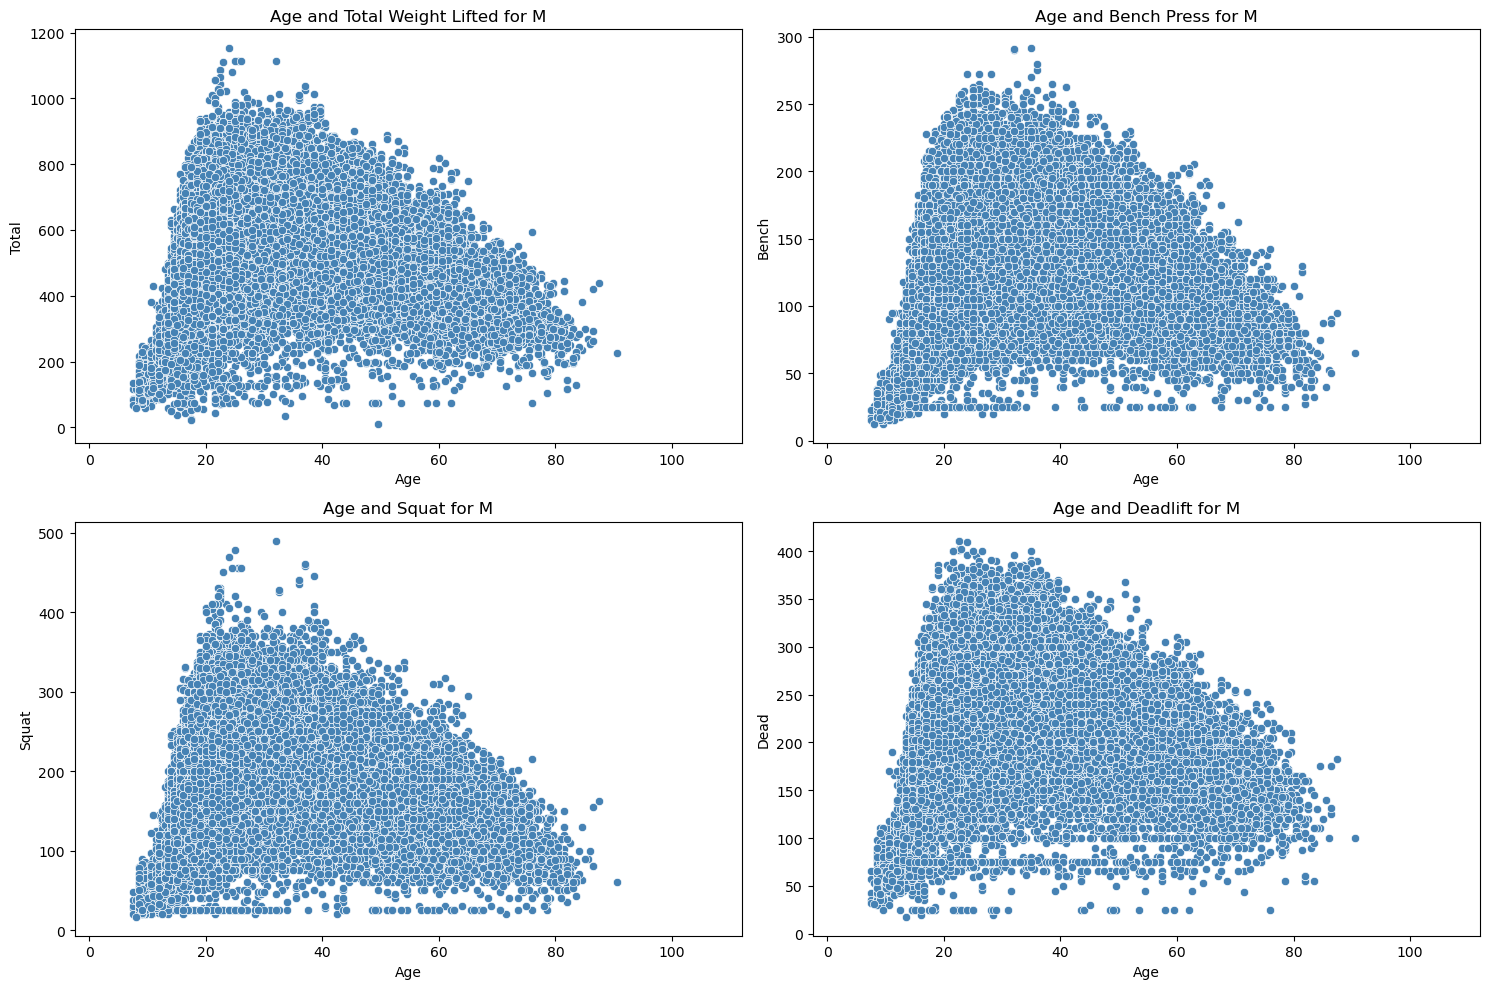

In [7]:
quadrant(total,bench,squat,dead,'M','Scatter')

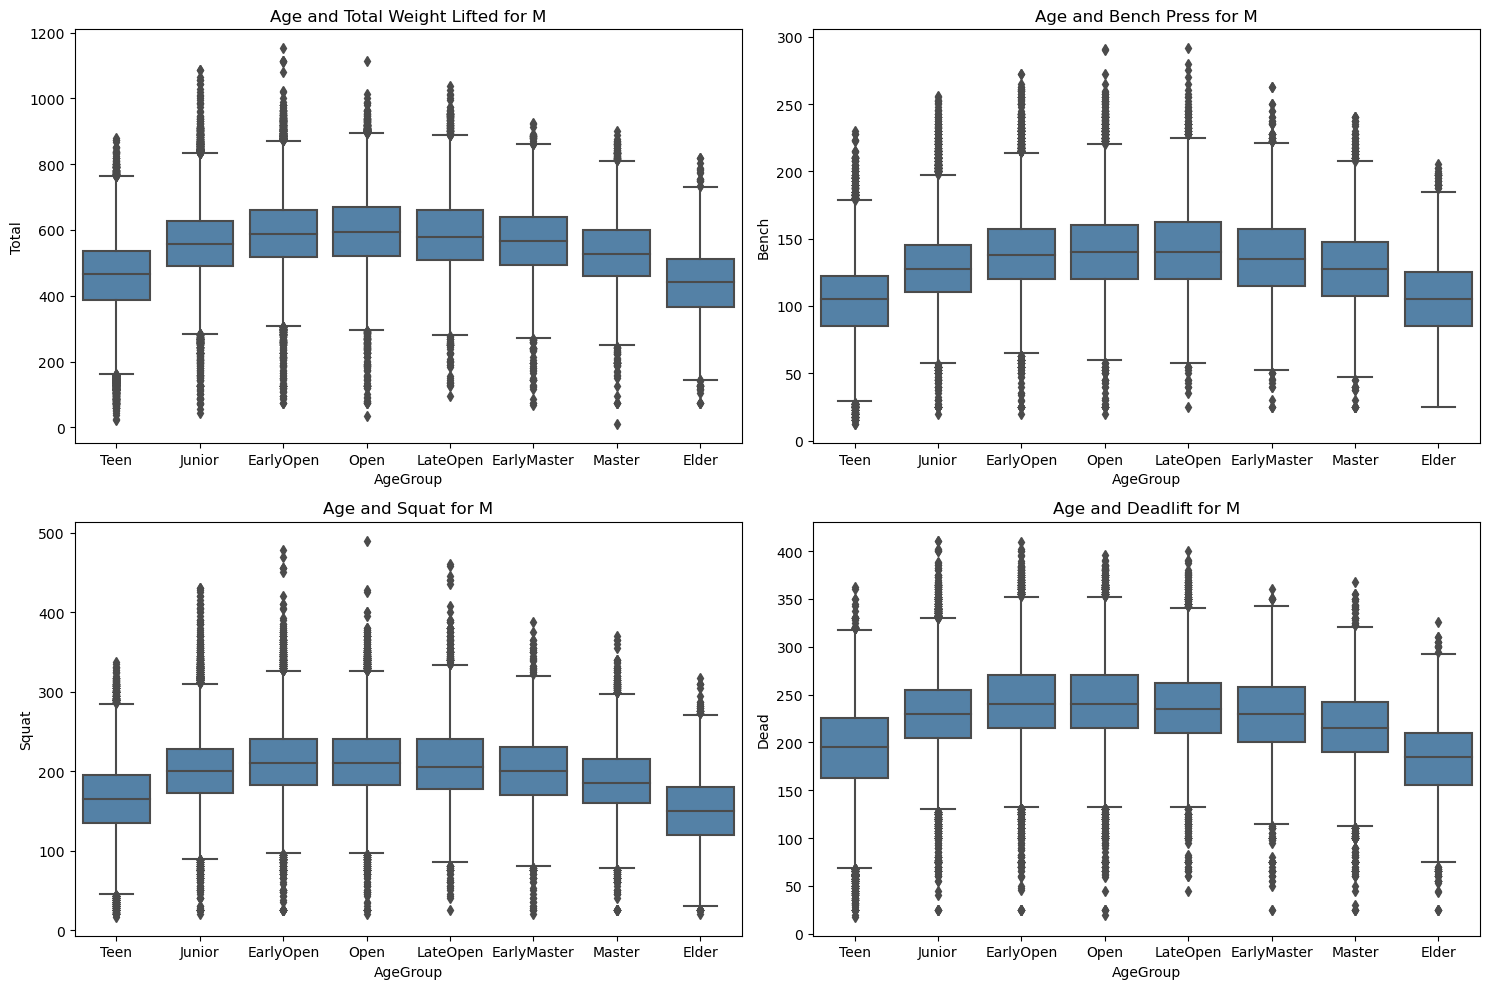

In [8]:
quadrant(total,bench,squat,dead,'M','Box')

Sex = F

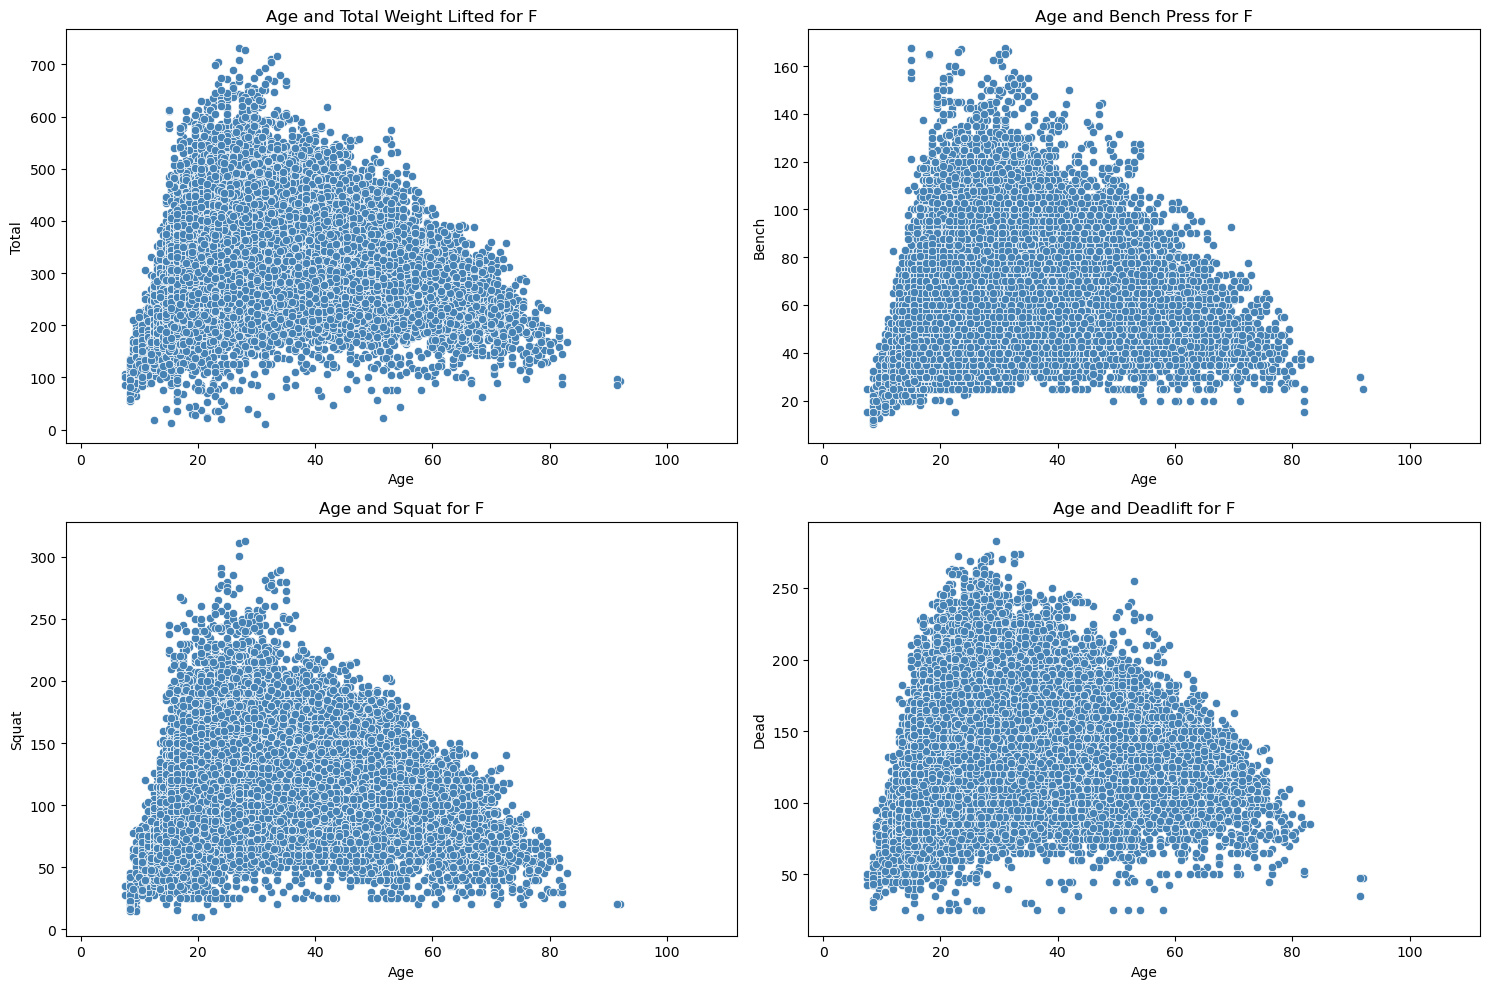

In [9]:
# Female
quadrant(total,bench,squat,dead,'F','Scatter')

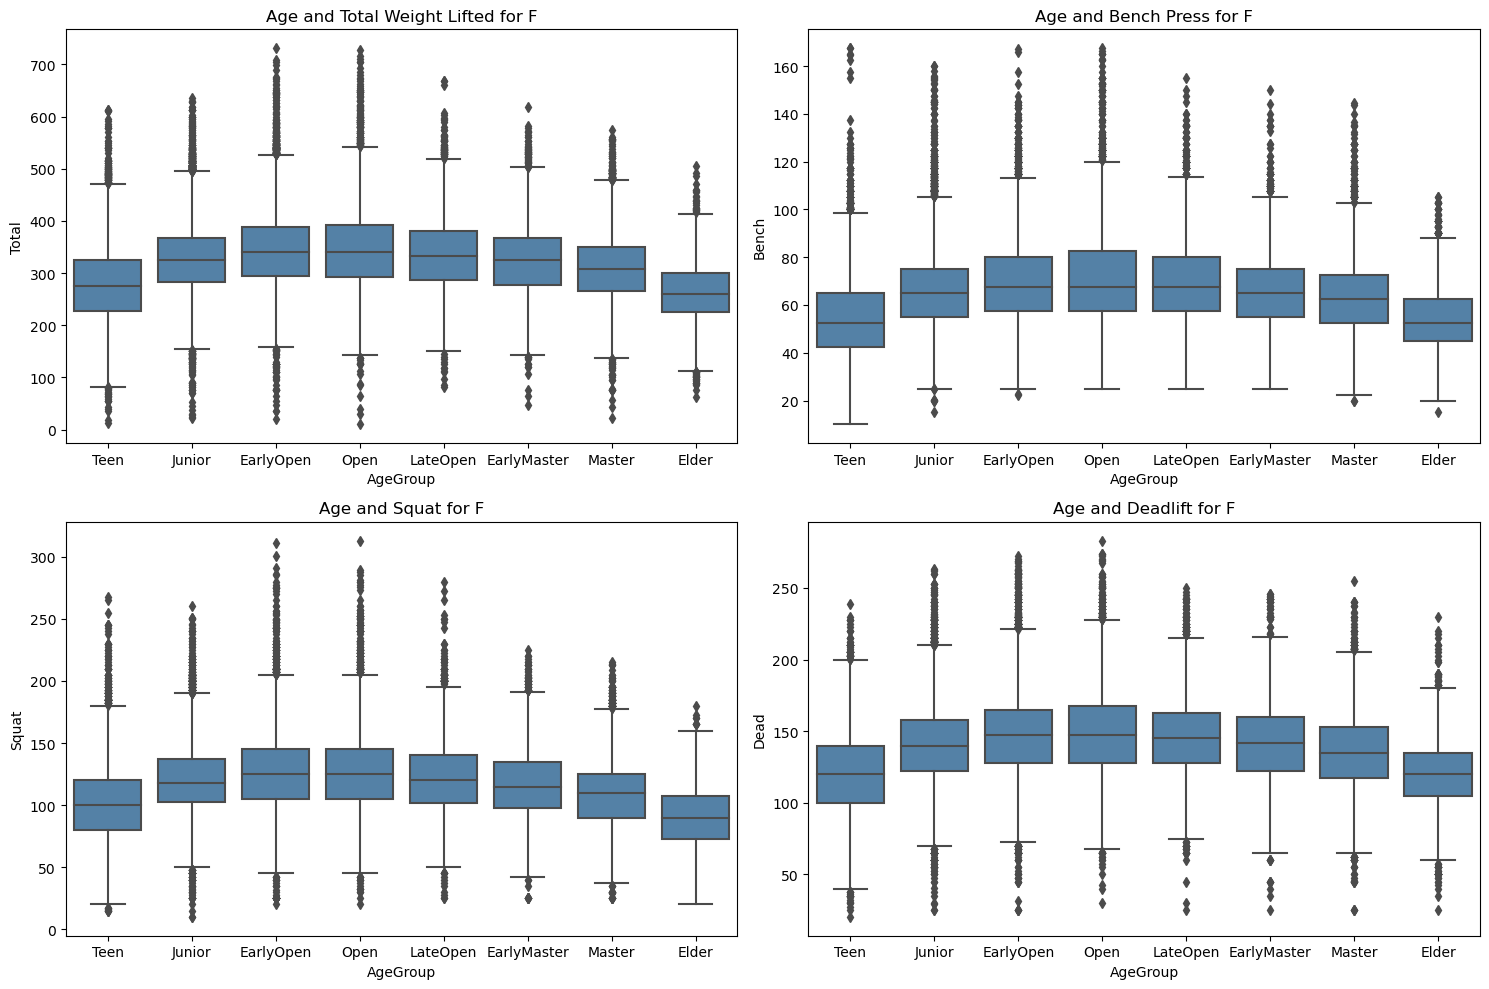

In [10]:
quadrant(total,bench,squat,dead,'F','Box')

Take a random sample for each age group

In [11]:
age_groups = df['AgeGroup'].unique()

def sample(total, n):
    dfs = pd.DataFrame()
    for x in range(len(age_groups)):
        a = total[total['AgeGroup']==age_groups[x]].copy()
        aa = a.sample(n = 500).copy()
        dfs = pd.concat([dfs,aa], axis = 0, ignore_index = True)
    return dfs

Sex = M

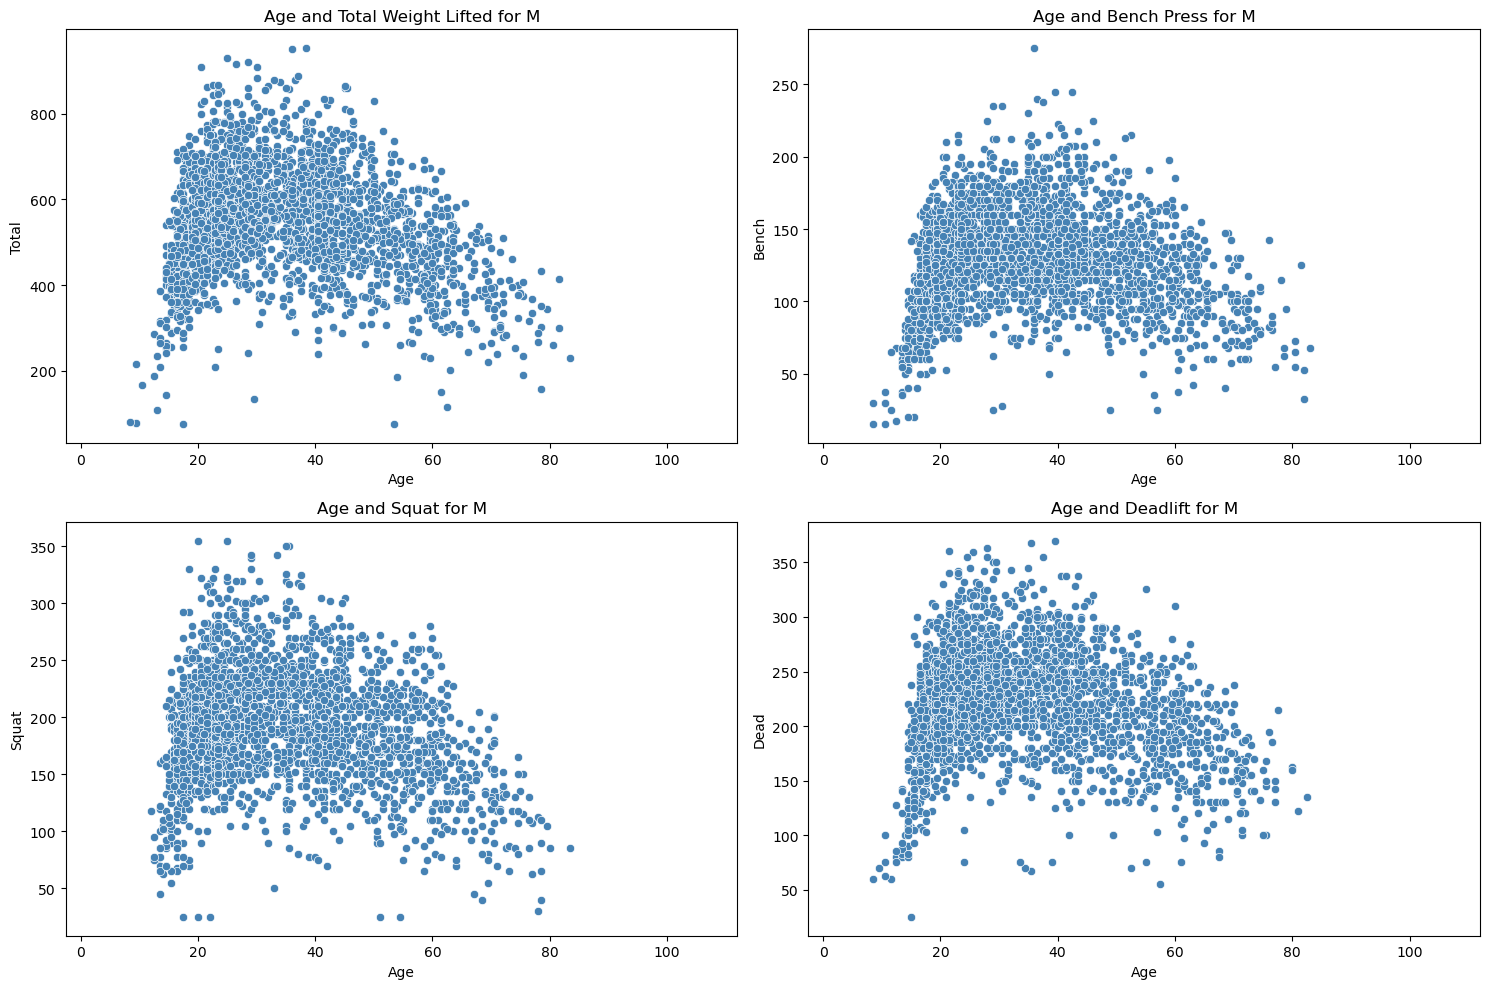

In [12]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Scatter')

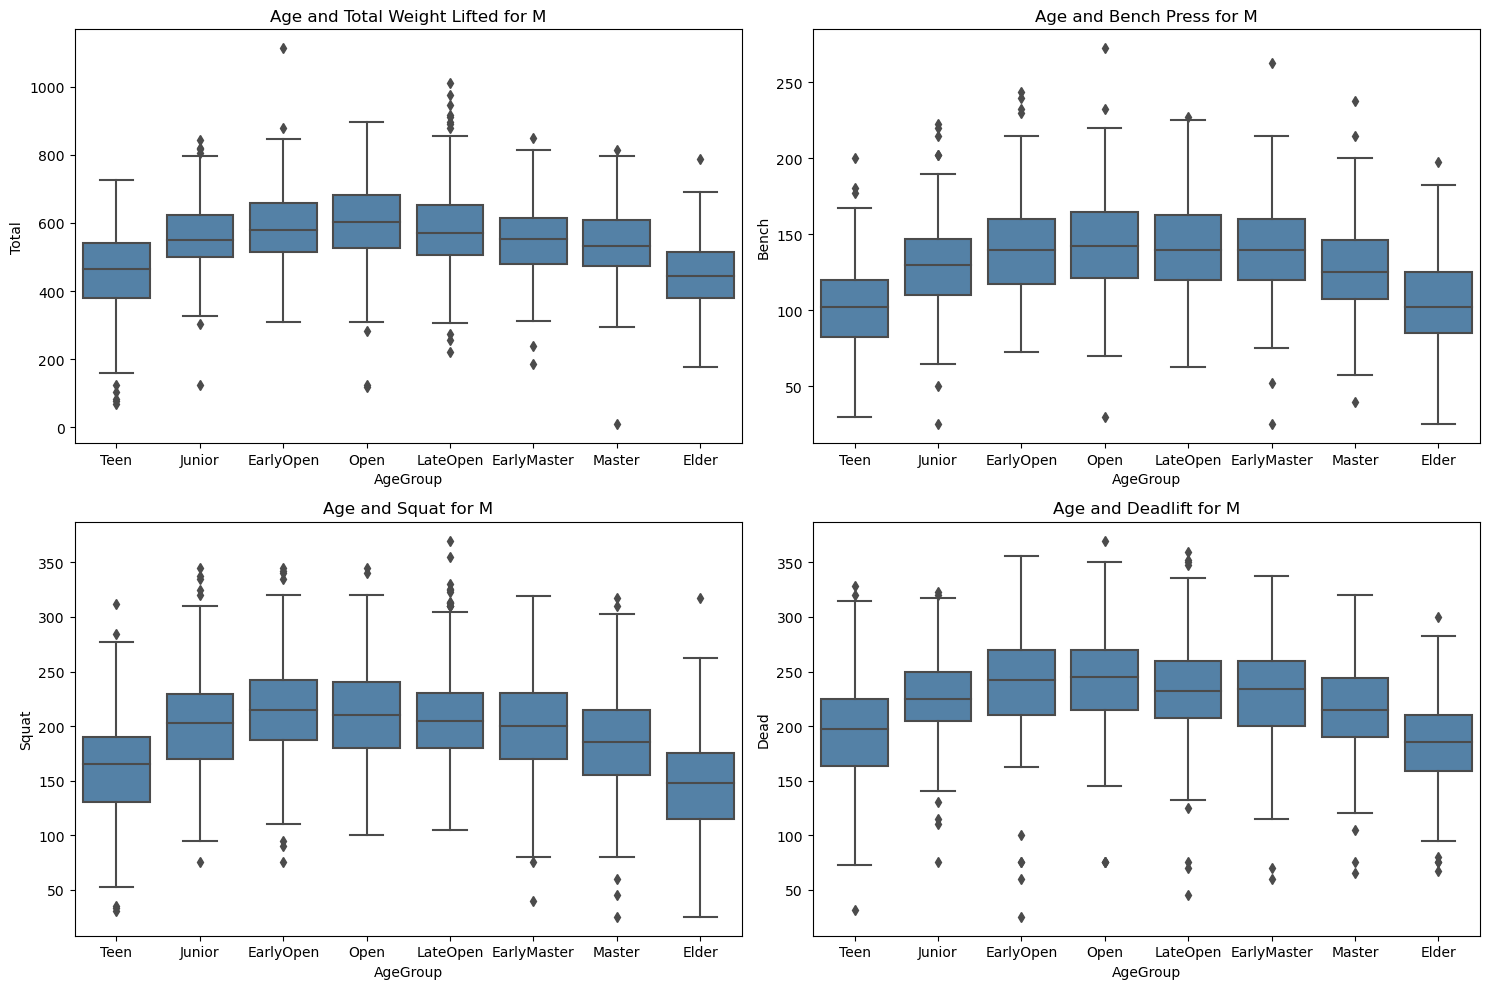

In [13]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Box')

Sex = F

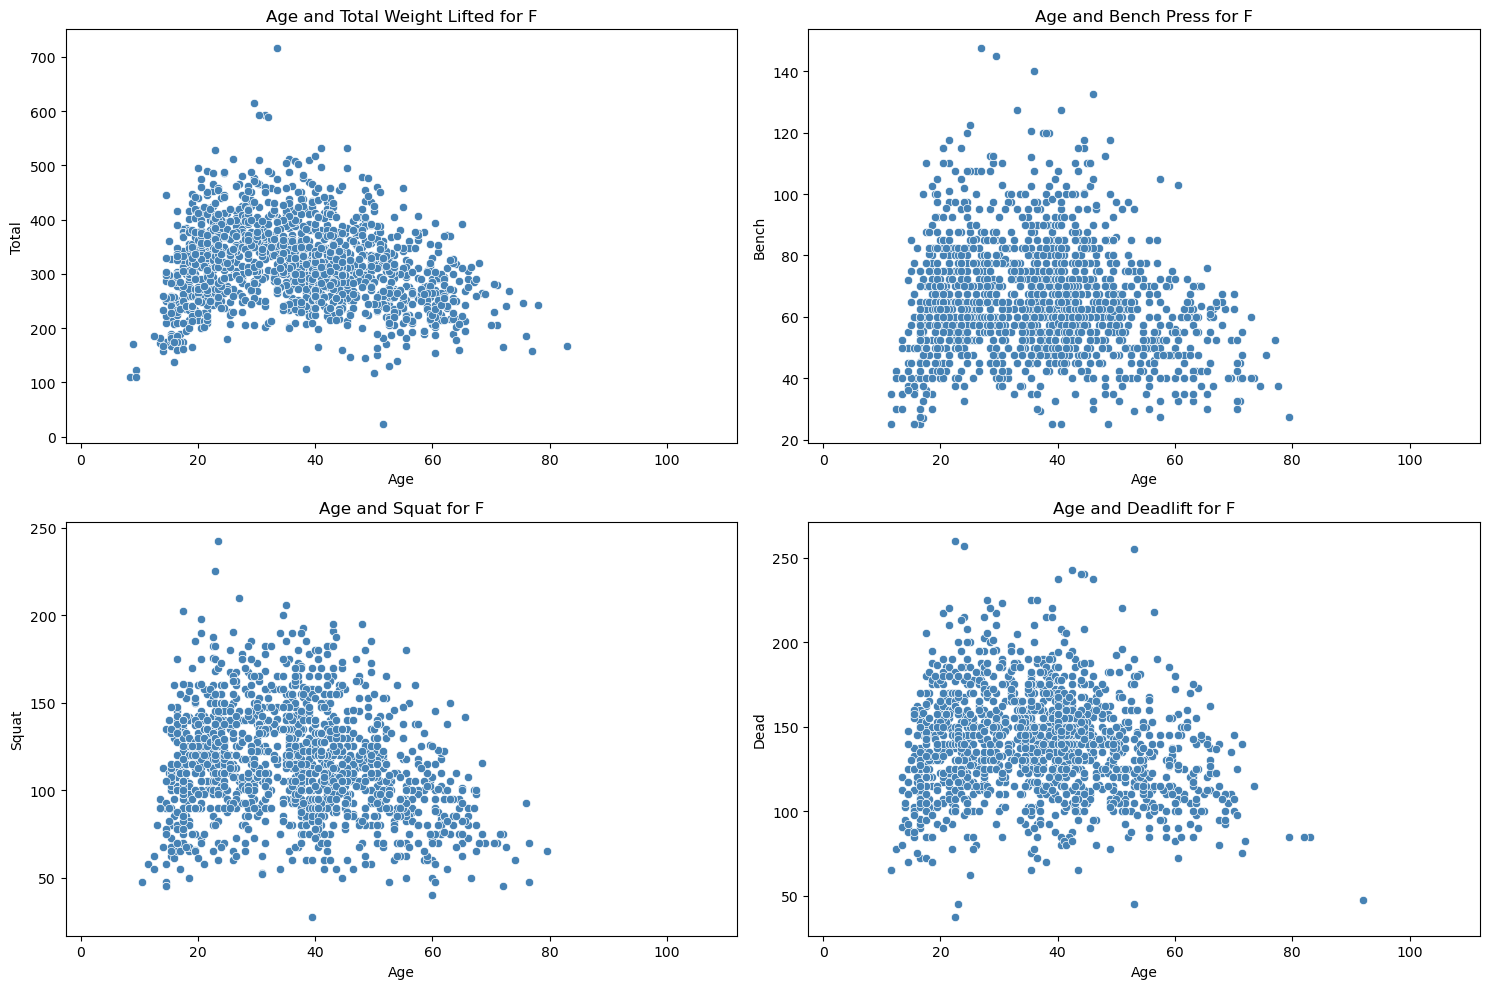

In [14]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Scatter')

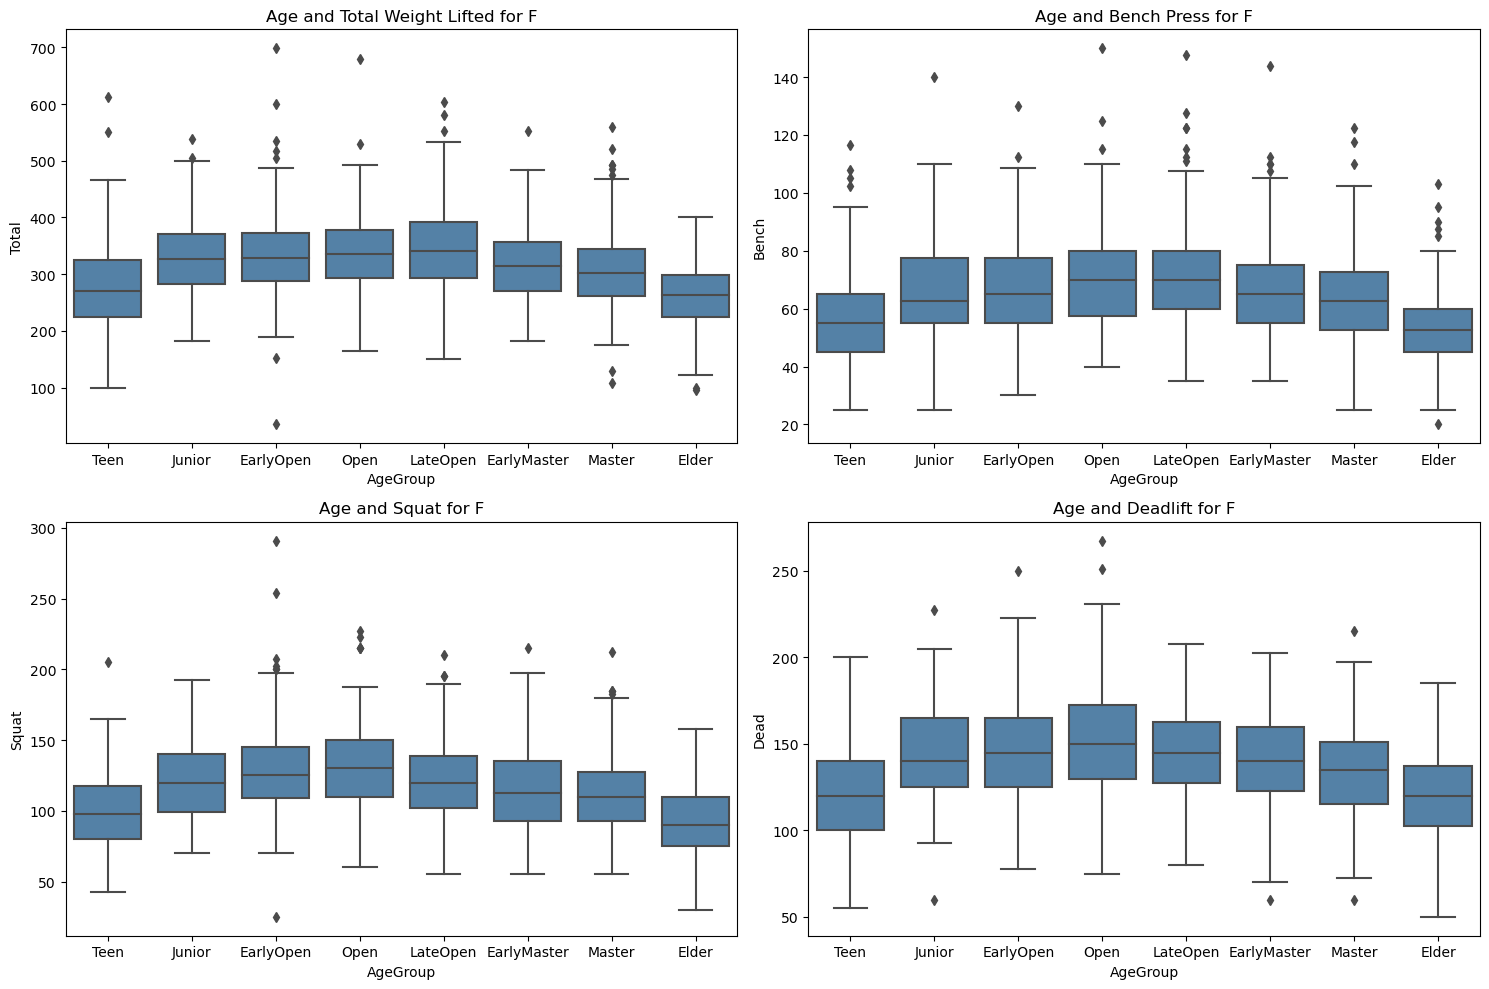

In [15]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Box')

Random Selected Sample Scatter Plot with Hue

In [16]:
def quadrant_hue(total,bench,squat,dead,sex,hue,group):
    fig,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))
    if group == 'Lighter':
        total = total[total['Weight'].isin(['Light','Middle'])]
        dead = dead[dead['Weight'].isin(['Light','Middle'])]
        squat = squat[squat['Weight'].isin(['Light','Middle'])]
        bench = bench[bench['Weight'].isin(['Light','Middle'])]
    elif group == 'Heavier':
        total = total[total['Weight'].isin(['Heavy','SuperHeavy'])]
        dead = dead[dead['Weight'].isin(['Heavy','SuperHeavy'])]
        squat = squat[squat['Weight'].isin(['Heavy','SuperHeavy'])]
        bench = bench[bench['Weight'].isin(['Heavy','SuperHeavy'])]
    
    axs[0,0].set_title('Age and Total Weight Lifted for '+sex)
    axs[0,1].set_title('Age and Bench Press for '+sex)
    axs[1,0].set_title('Age and Squat for '+sex)
    axs[1,1].set_title('Age and Deadlift for '+sex)

    common_xlim = (min(df['Age'])-10, max(df['Age'])+20)
    
    axs[0, 0].set_xlim(common_xlim)
    axs[0, 1].set_xlim(common_xlim)
    axs[1, 0].set_xlim(common_xlim)
    axs[1, 1].set_xlim(common_xlim)

    hue_order = total[hue].unique()

    palette = sns.color_palette('Accent', n_colors=len(hue_order))

    sns.scatterplot(data=total[total['Sex'] == sex].copy(), x='Age', y='Total', ax=axs[0, 0],
                    hue=hue, palette=palette, hue_order=hue_order)
    sns.scatterplot(data=bench[bench['Sex'] == sex].copy(), x='Age', y='Bench', ax=axs[0, 1],
                    hue=hue, palette=palette, hue_order=hue_order)
    sns.scatterplot(data=squat[squat['Sex'] == sex].copy(), x='Age', y='Squat', ax=axs[1, 0],
                    hue=hue, palette=palette, hue_order=hue_order)
    sns.scatterplot(data=dead[dead['Sex'] == sex].copy(), x='Age', y='Dead', ax=axs[1, 1],
                    hue=hue, palette=palette, hue_order=hue_order)
    plt.tight_layout()

Sex = M

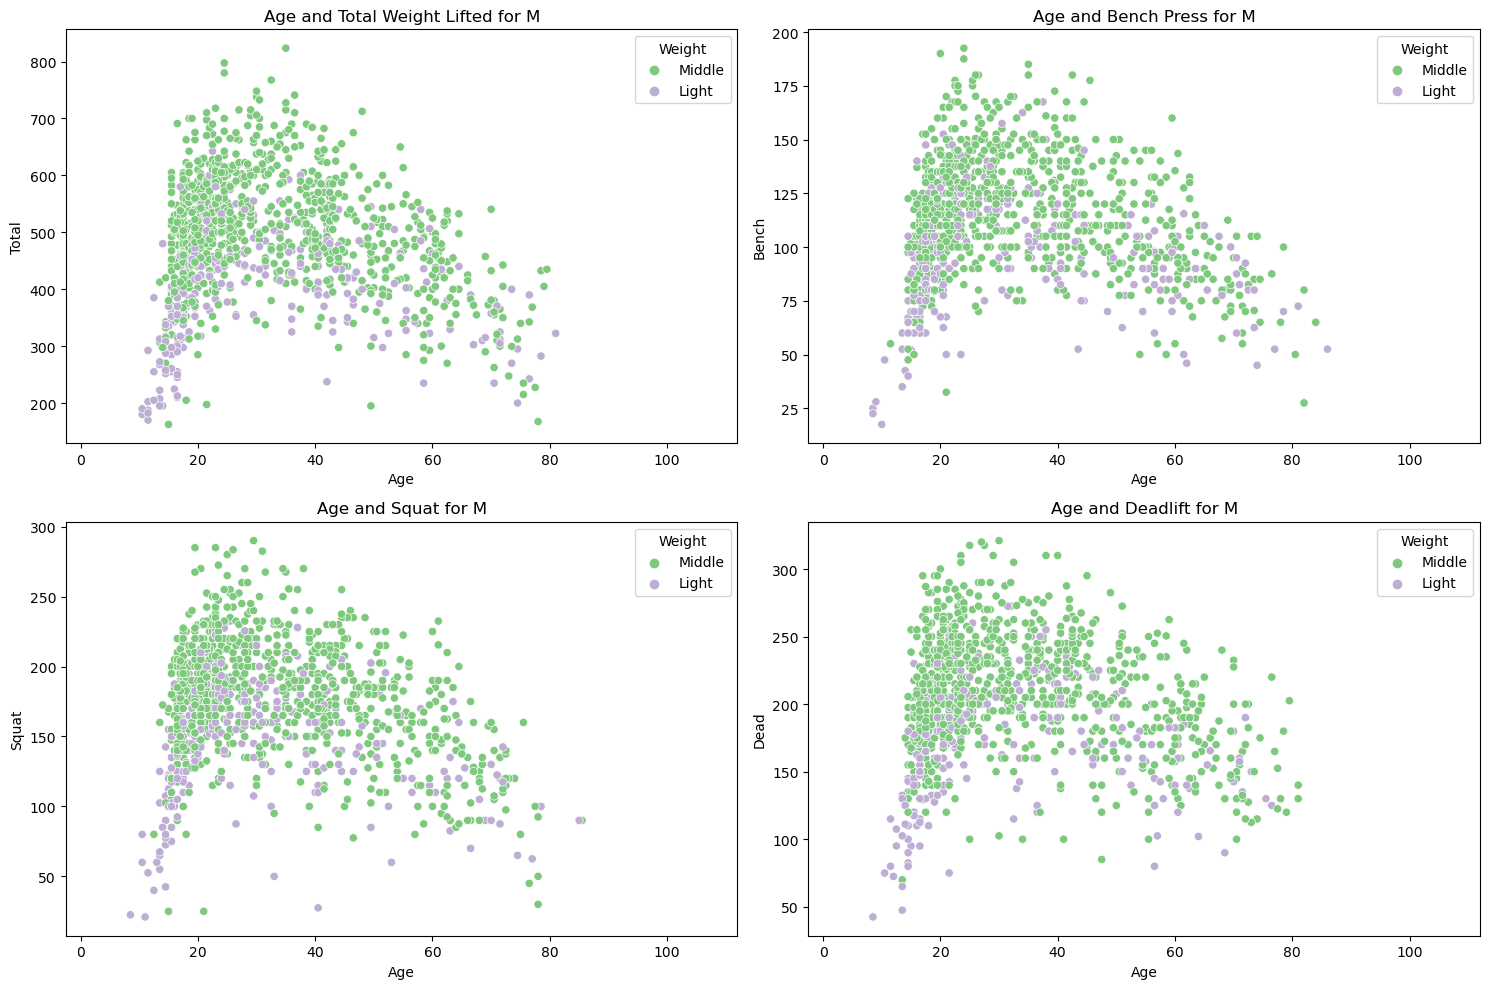

In [17]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Weight','Lighter')

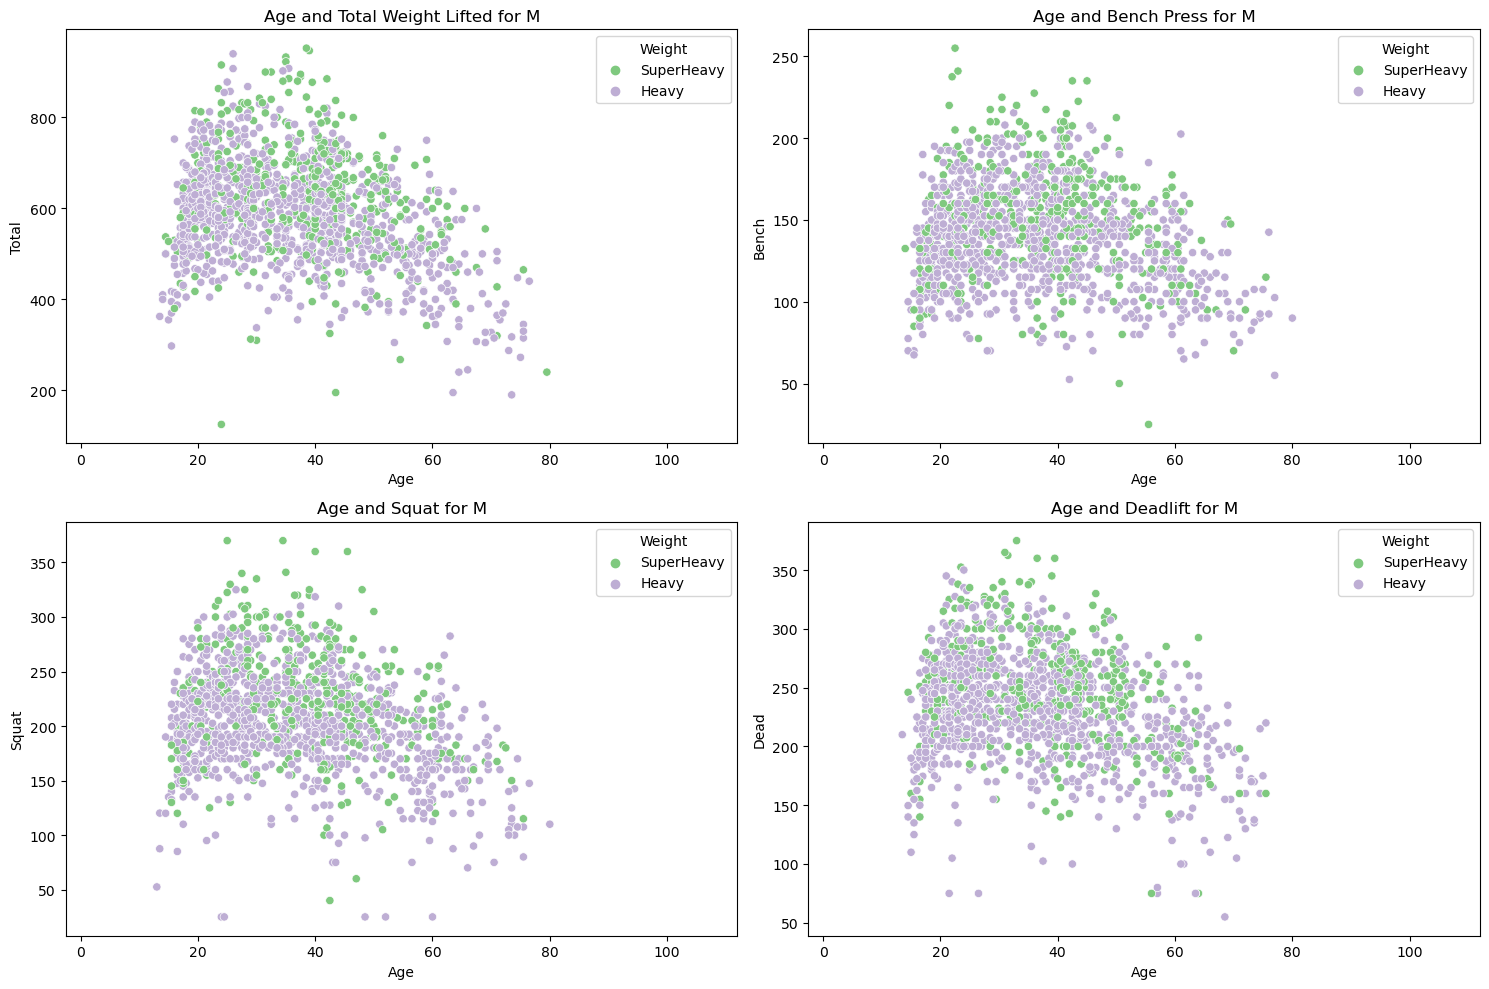

In [18]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Weight','Heavier')

Sex = F

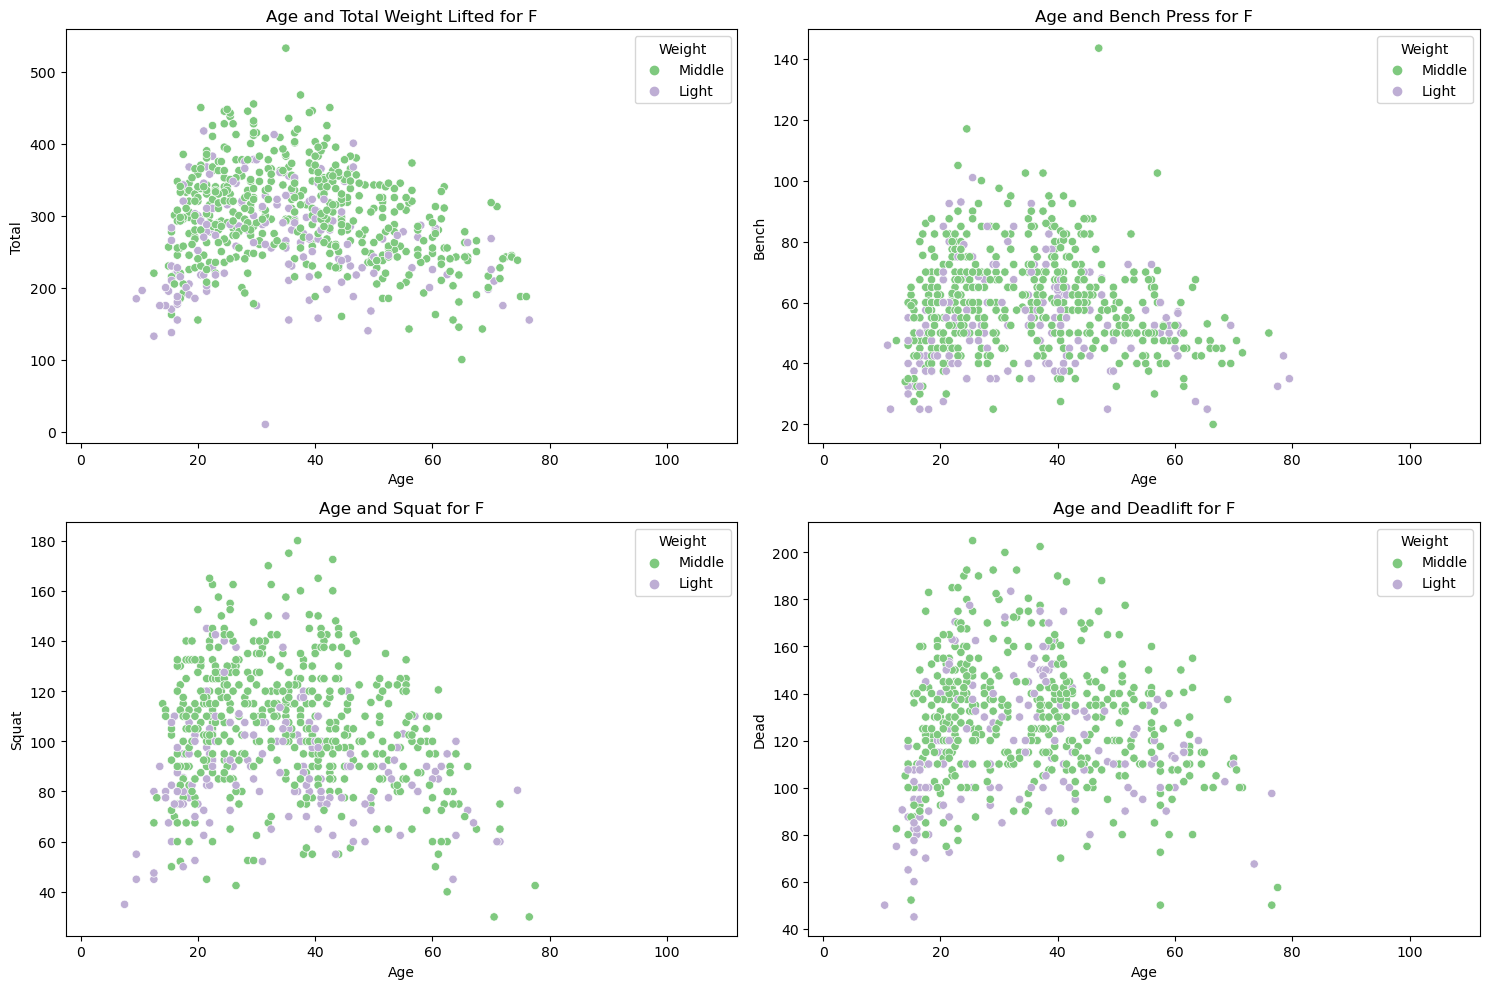

In [19]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Weight','Lighter')

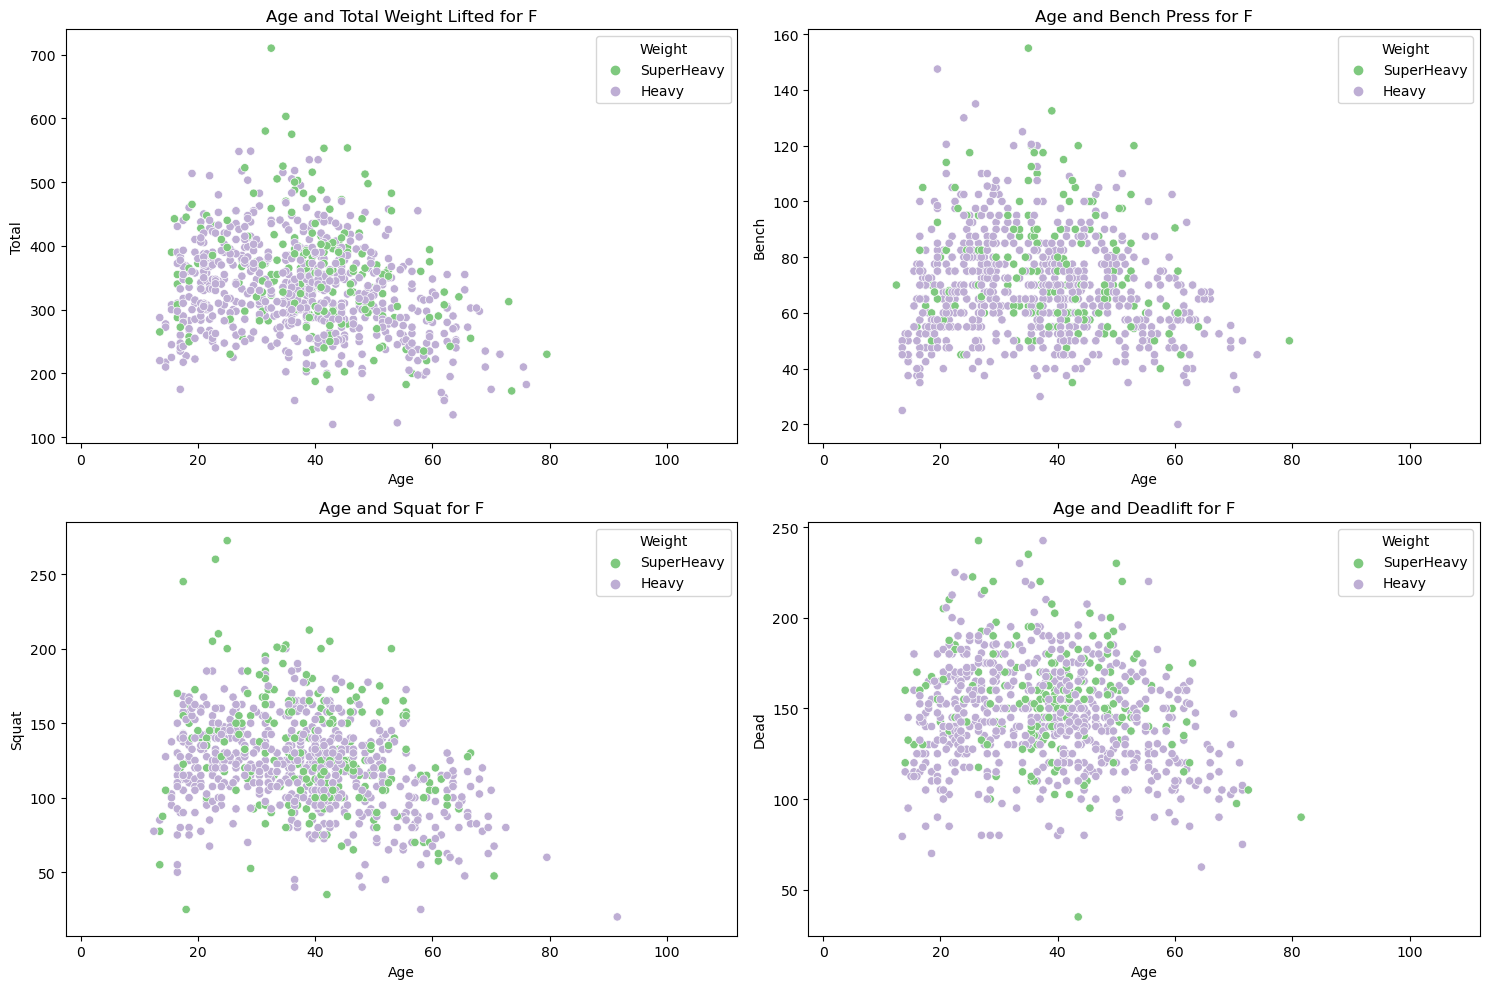

In [20]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Weight','Heavier')

# 1) Gaussian Distribution of Strength Cutoffs

Explore normality between Age Groups and Peak Strength levels across Total, Bench, Dead, and Squat

In [21]:
def max_strength(total, sex):
    summary = pd.DataFrame()
    col = total.columns[2] # selects total, bench, squat, or dead
    cutoff = total[total['Sex'] == sex].groupby('AgeGroup')[col].quantile(.9).reset_index().copy()
    return cutoff

def shapiro_wilk(total, sex, alpha):
    a = max_strength(total, sex)
    col = total.columns[2]
    stat, p = stats.shapiro(a[col])
    if p > alpha:
        return 'The data appears to be normally distributed (fail to reject H0)'
    else:
        return 'The data does not appear to be normally distributed (reject H0)'
        
def bar_quadrant(total, bench, squat, dead, sex):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    axs[0, 0].set_title('Top Total per Age Group for ' + sex)
    axs[0, 1].set_title('Top Bench Press per Age Group for ' + sex)
    axs[1, 0].set_title('Top Squat per Age Group for ' + sex)
    axs[1, 1].set_title('Top Deadlift per Age Group for ' + sex)

    sns.barplot(max_strength(total, sex), x='AgeGroup', y='Total', color='steelblue', ax=axs[0, 0])
    sns.barplot(max_strength(bench, sex), x='AgeGroup', y='Bench', color='steelblue', ax=axs[0, 1])
    sns.barplot(max_strength(squat, sex), x='AgeGroup', y='Squat', color='steelblue', ax=axs[1, 0])
    sns.barplot(max_strength(dead, sex), x='AgeGroup', y='Dead', color='steelblue', ax=axs[1, 1])
    
    total_conclusion = shapiro_wilk(total, sex, alpha=0.05)
    bench_conclusion = shapiro_wilk(bench, sex, alpha=0.05)
    squat_conclusion = shapiro_wilk(squat, sex, alpha=0.05)
    dead_conclusion = shapiro_wilk(dead, sex, alpha=0.05)
    for ax in axs.flat:
        for bar in ax.patches:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                    round(bar.get_height(), 2), ha='center', va='bottom')
        
    axs[0, 0].text(0.5, -0.2, total_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[0, 0].transAxes, fontsize=10, color='red')
    axs[0, 1].text(0.5, -0.2, bench_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[0, 1].transAxes, fontsize=10, color='red')
    axs[1, 0].text(0.5, -0.2, squat_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[1, 0].transAxes, fontsize=10, color='red')
    axs[1, 1].text(0.5, -0.2, dead_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[1, 1].transAxes, fontsize=10, color='red')

    plt.tight_layout()


Null Hypothesis: The distribution of Top Strength per Age Group is normally distributed.

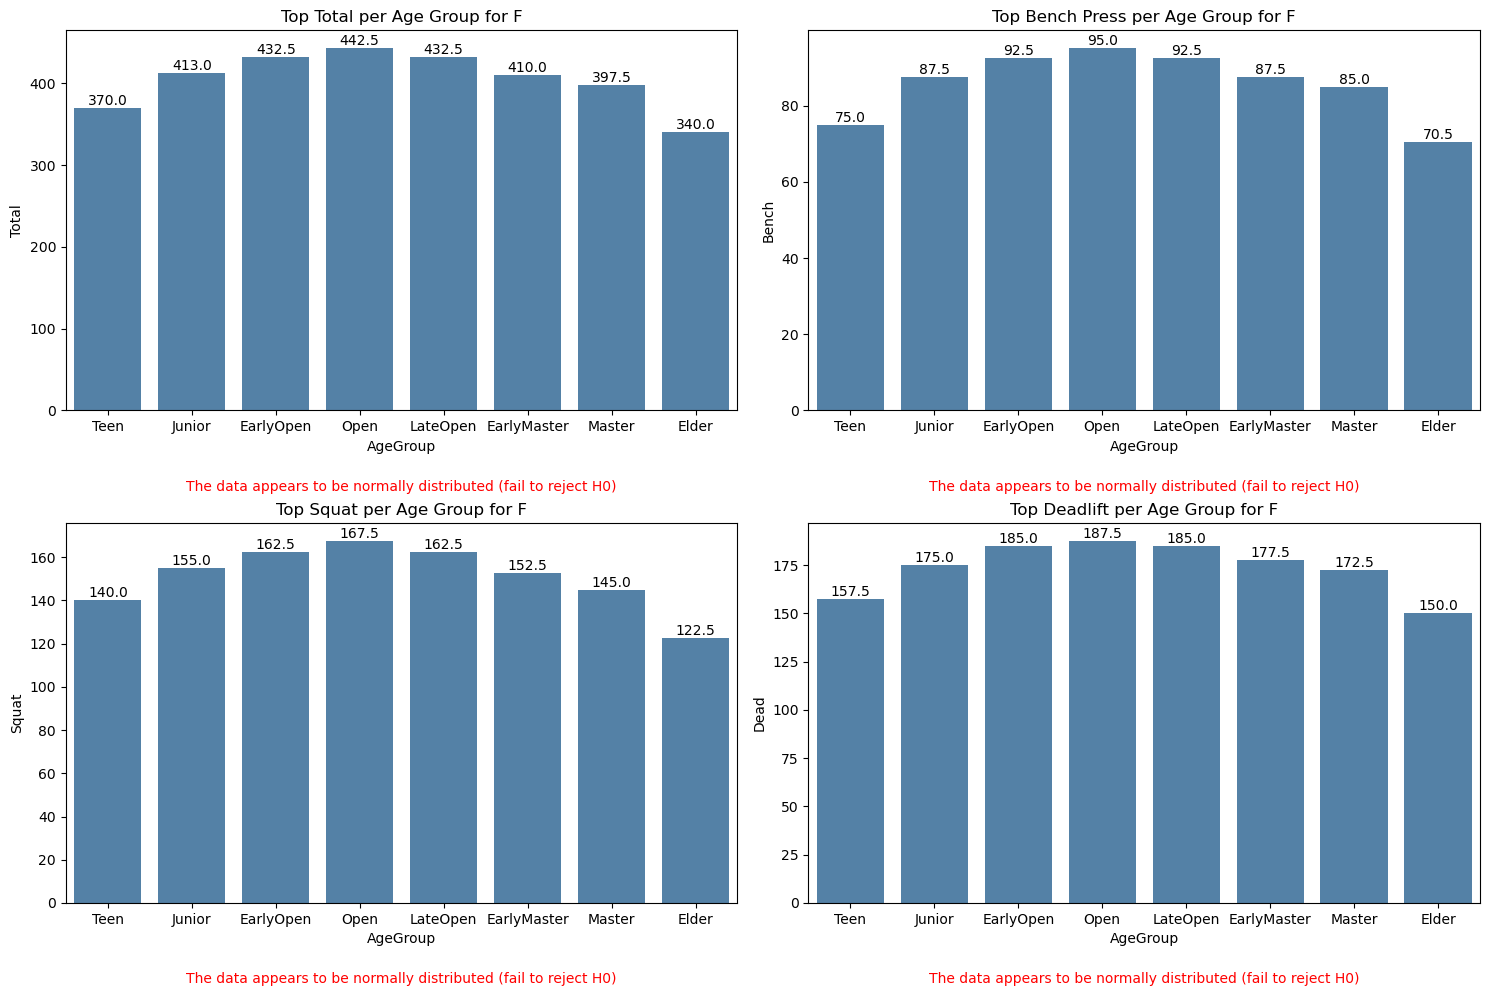

In [22]:
bar_quadrant(total,bench,squat,dead,'F')

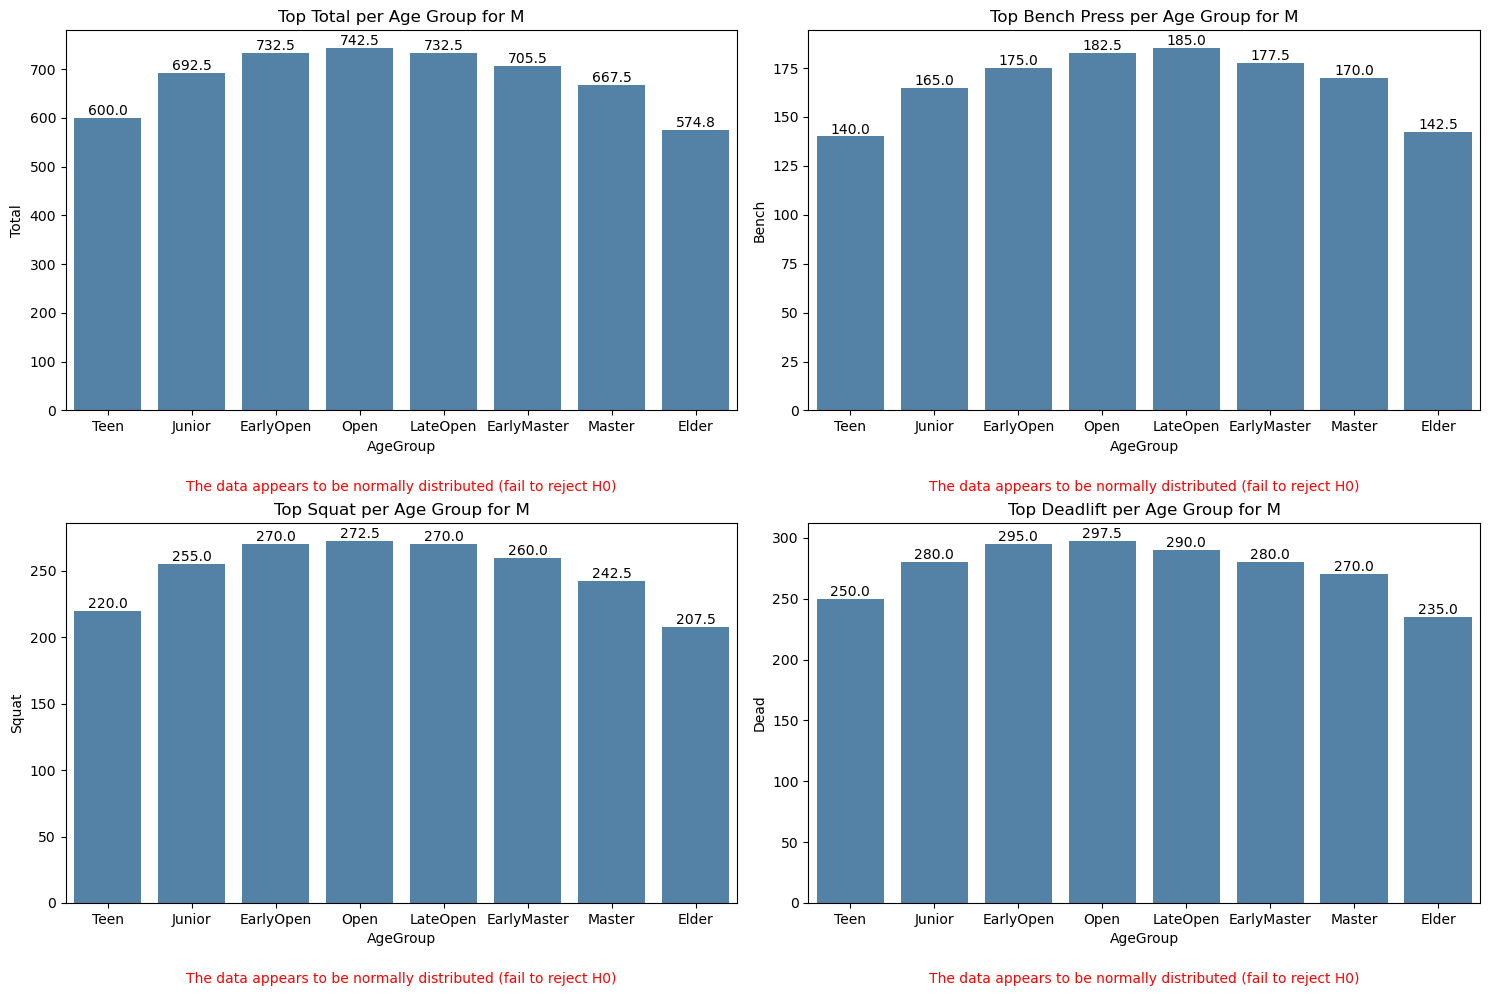

In [23]:
bar_quadrant(total,bench,squat,dead,'M')

The top strength across all age groups appear to be normally distributed, except for the Male bench press. Peak bench press appears to sustain through the Early Masters.

## Normality Test Across Age and Weight Groups

Sex = F

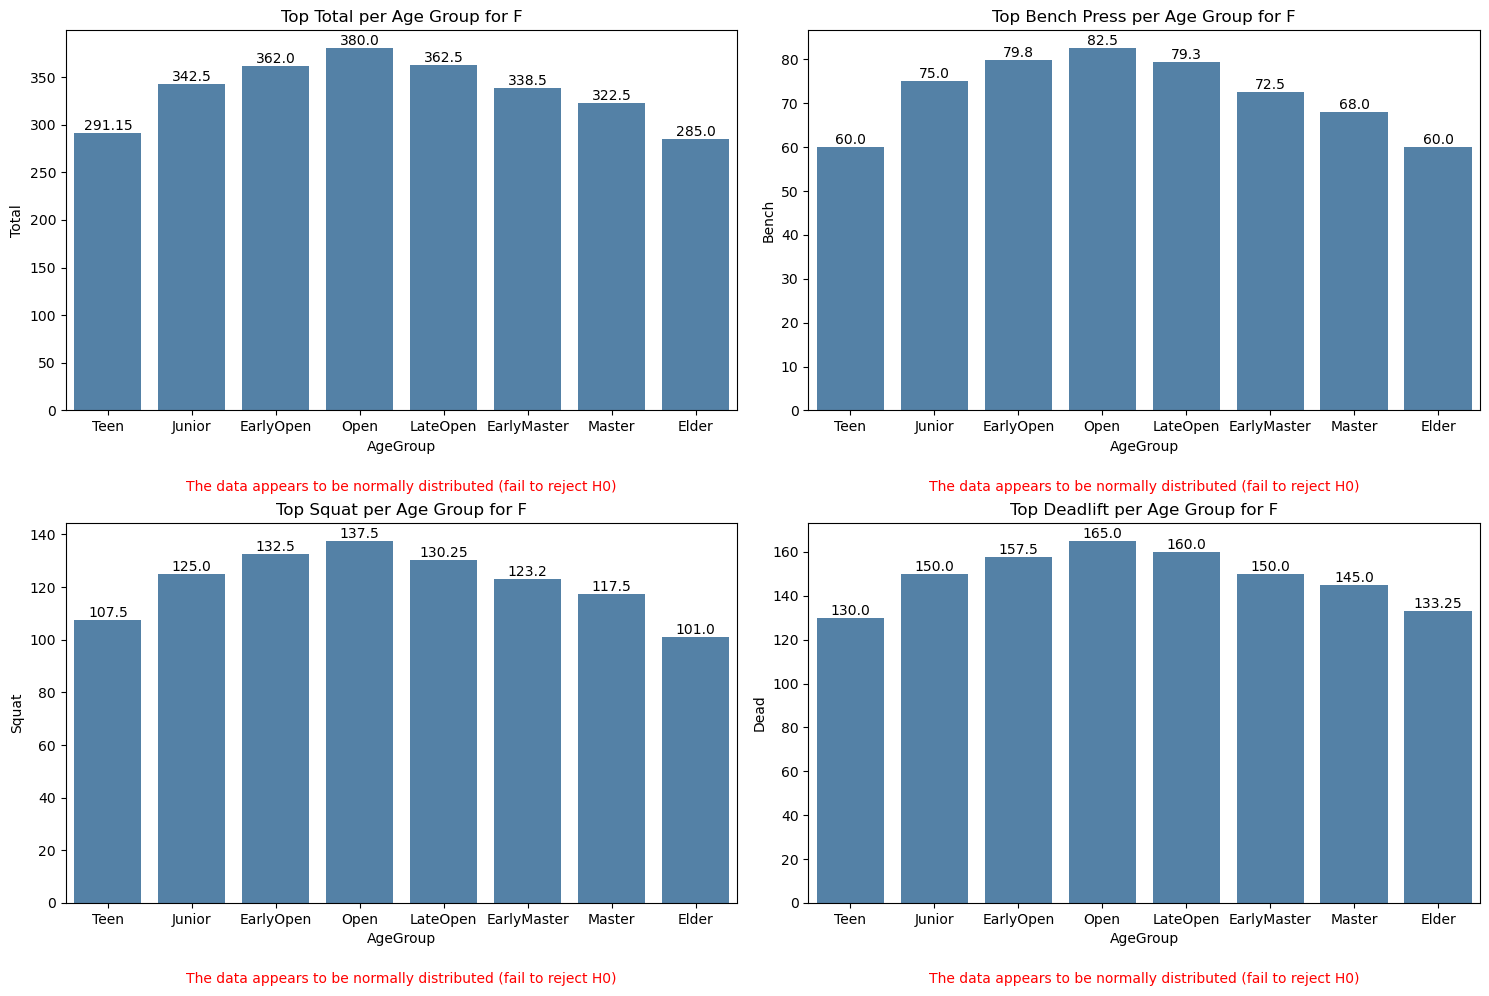

In [24]:
bar_quadrant(total[total['Weight']=='Light'],bench[bench['Weight']=='Light'],
             squat[squat['Weight']=='Light'],dead[dead['Weight']=='Light'],'F')

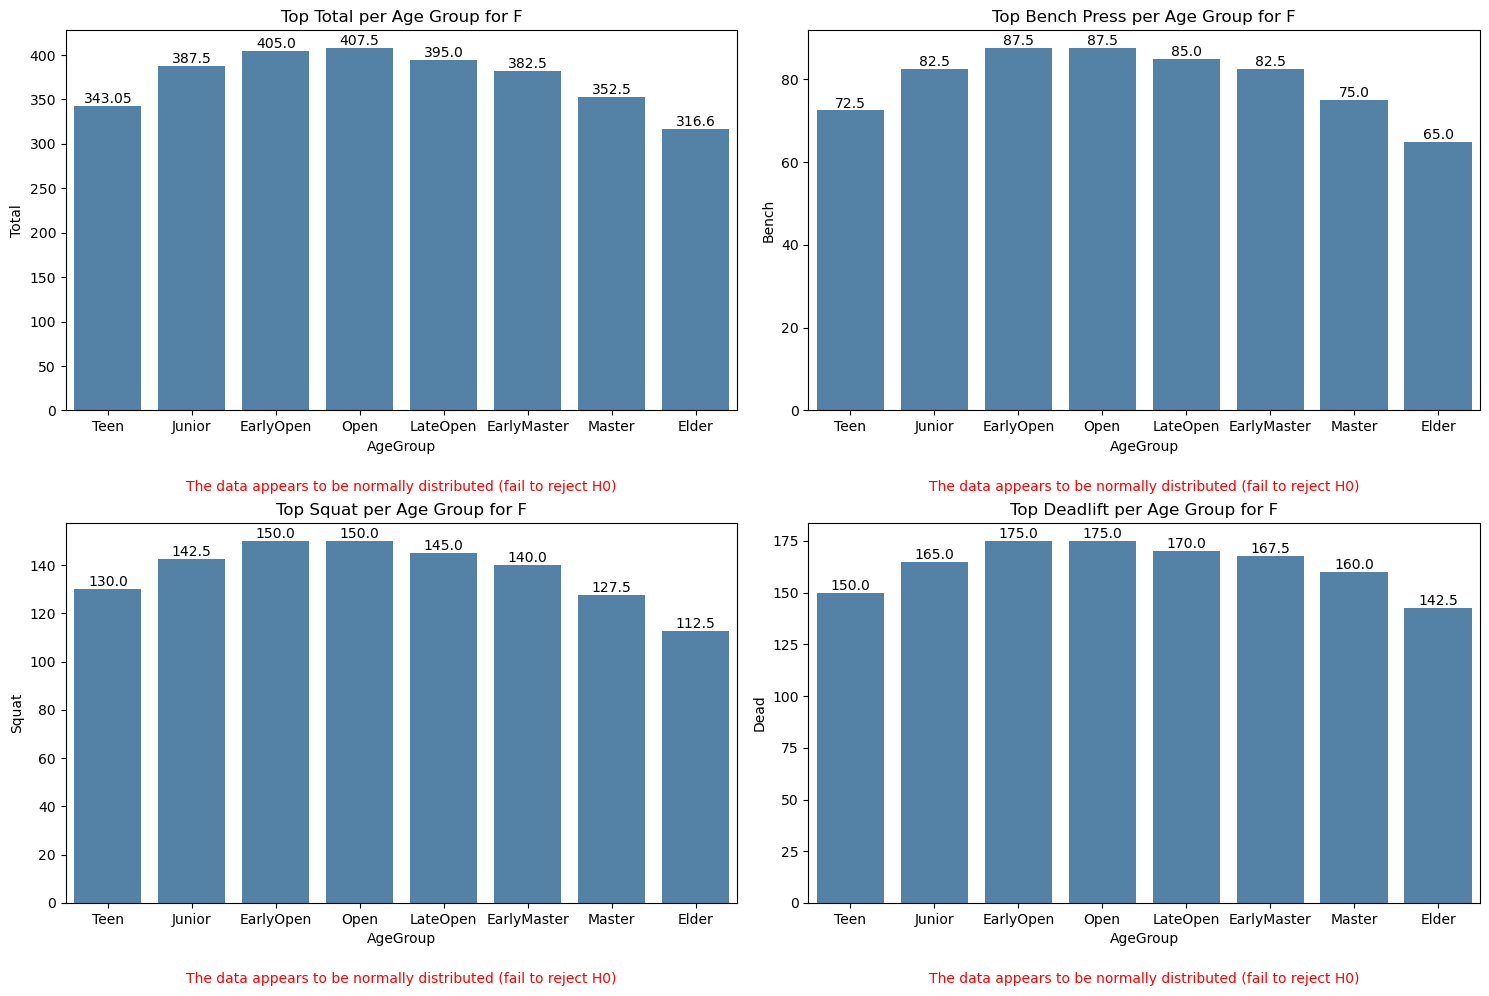

In [25]:
bar_quadrant(total[total['Weight']=='Middle'],bench[bench['Weight']=='Middle'],
             squat[squat['Weight']=='Middle'],dead[dead['Weight']=='Middle'],'F')

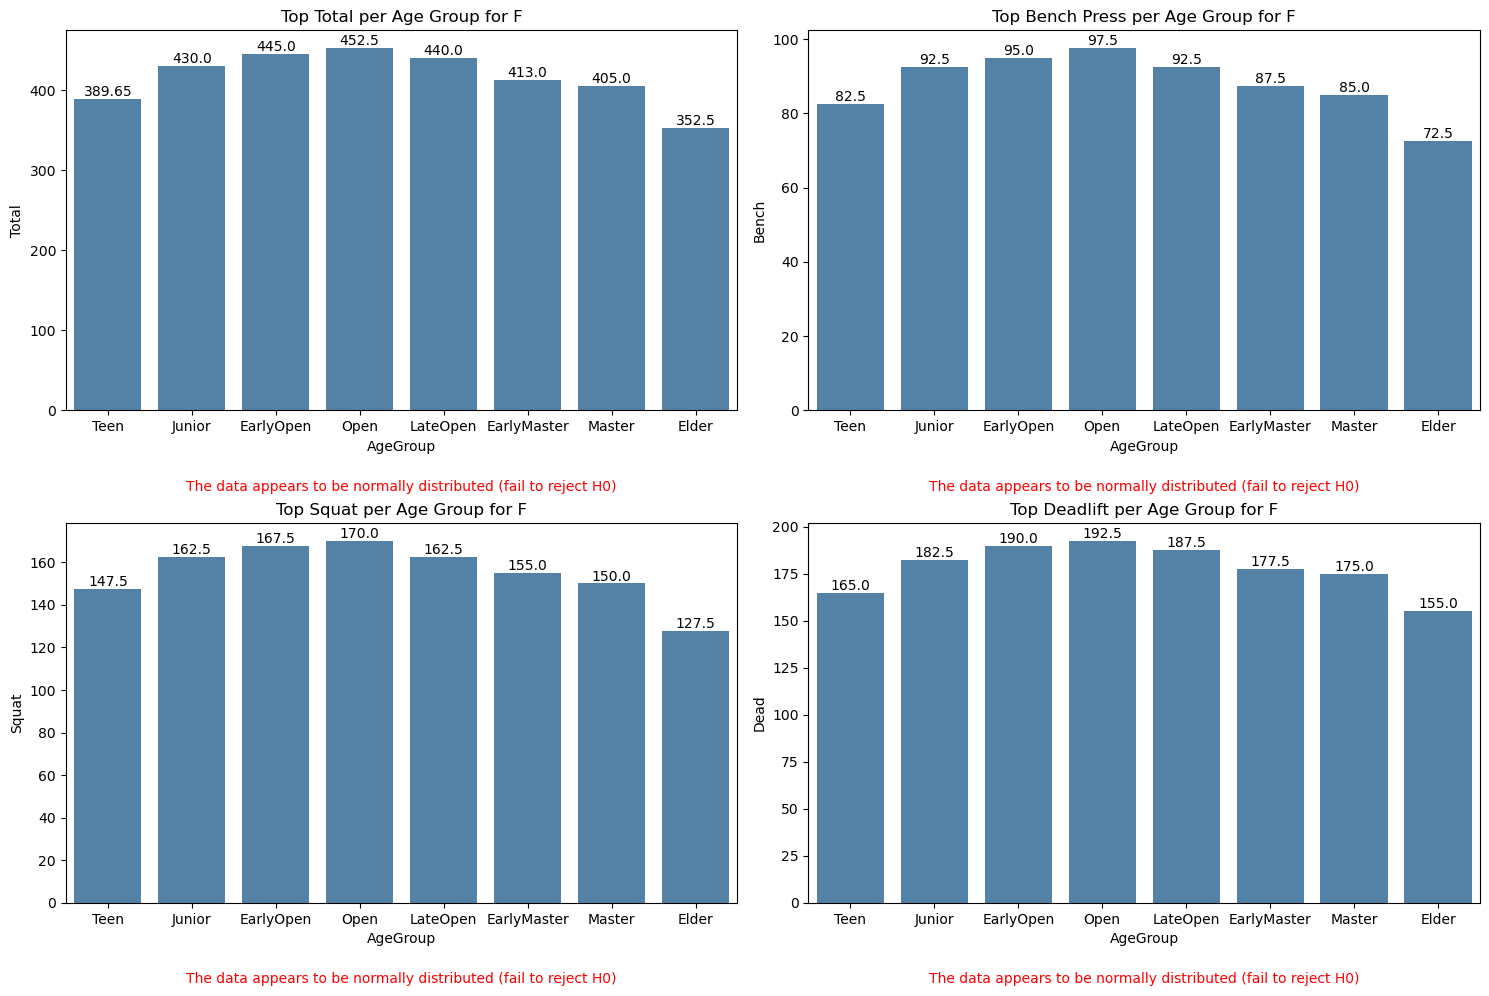

In [26]:
bar_quadrant(total[total['Weight']=='Heavy'],bench[bench['Weight']=='Heavy'],
             squat[squat['Weight']=='Heavy'],dead[dead['Weight']=='Heavy'],'F')

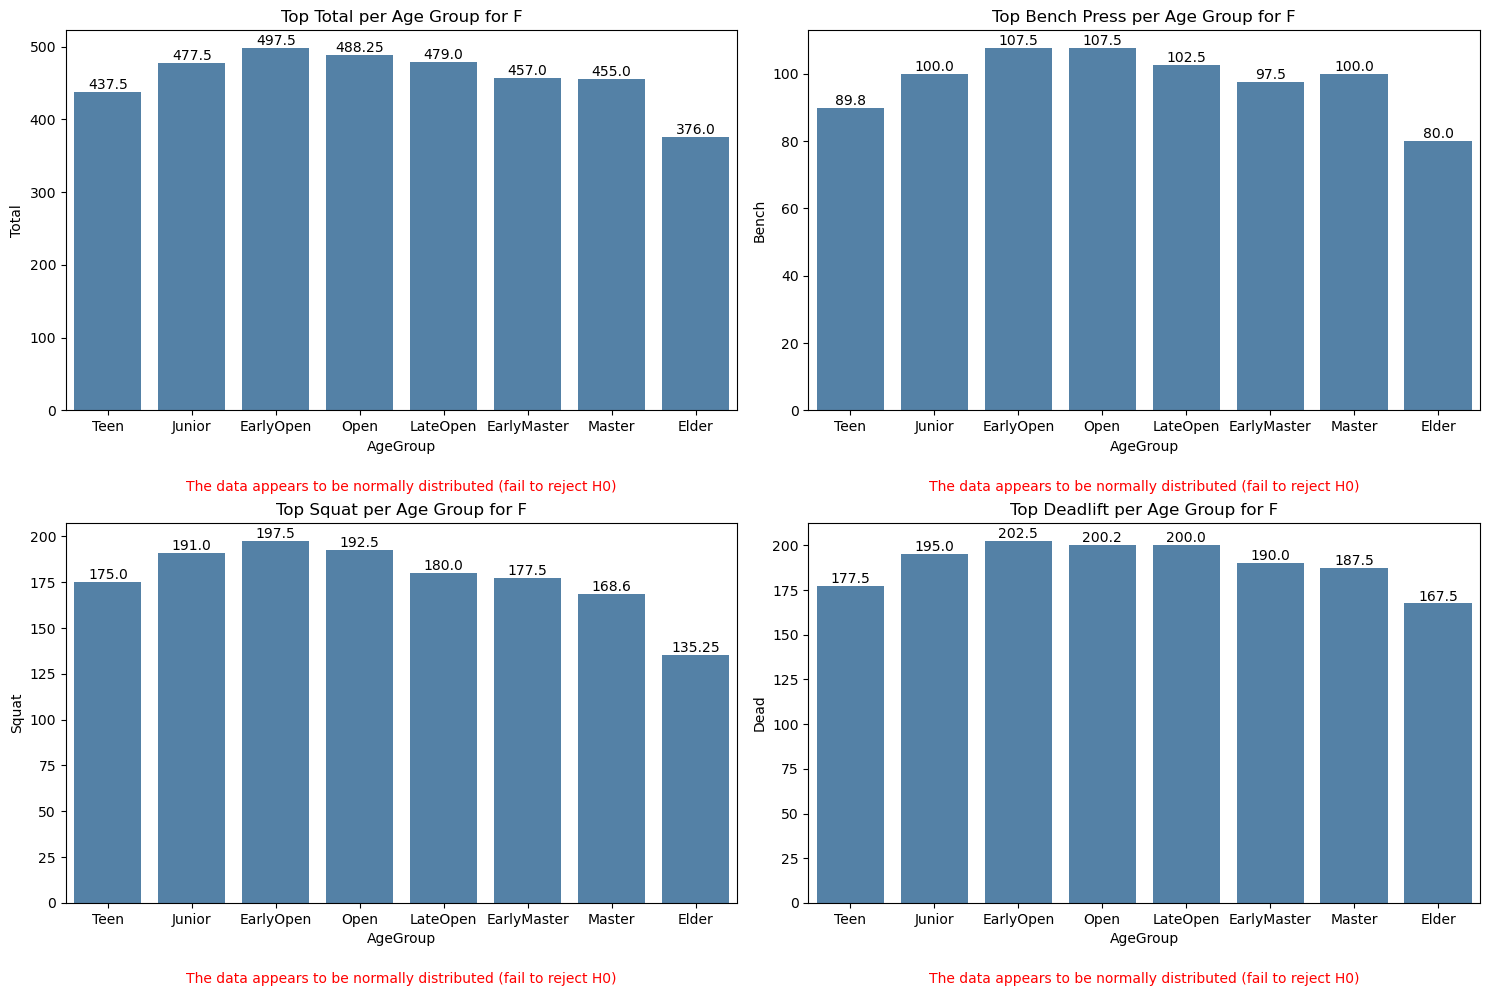

In [27]:
bar_quadrant(total[total['Weight']=='SuperHeavy'],bench[bench['Weight']=='SuperHeavy'],
             squat[squat['Weight']=='SuperHeavy'],dead[dead['Weight']=='SuperHeavy'],'F')

Sex = M

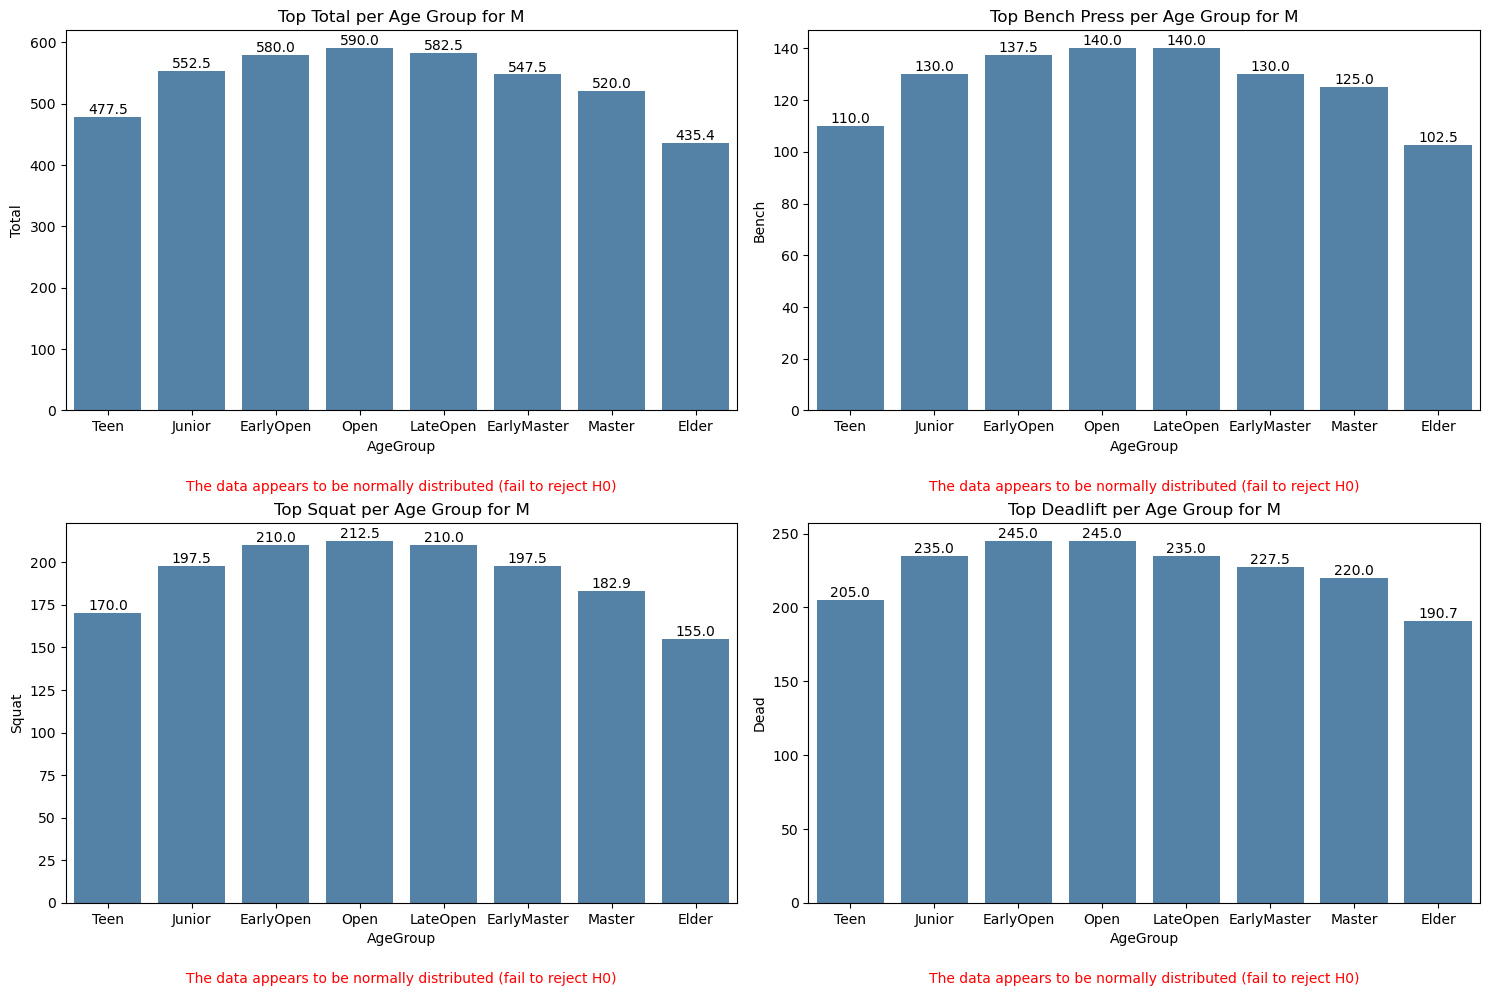

In [28]:
bar_quadrant(total[total['Weight']=='Light'],bench[bench['Weight']=='Light'],
             squat[squat['Weight']=='Light'],dead[dead['Weight']=='Light'],'M')

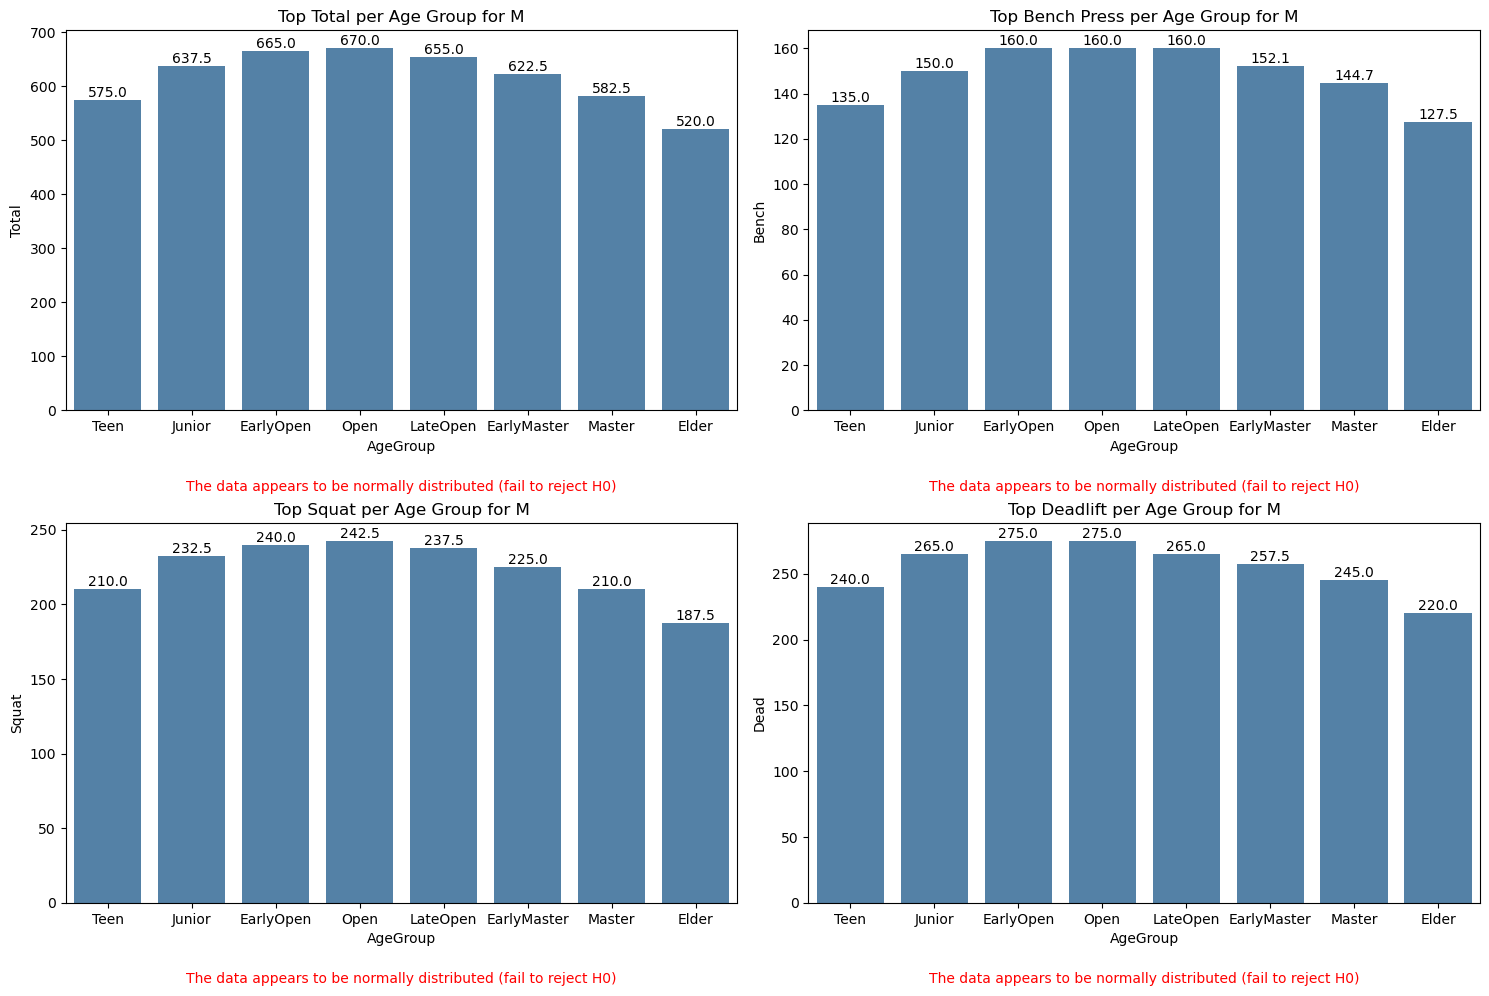

In [29]:
bar_quadrant(total[total['Weight']=='Middle'],bench[bench['Weight']=='Middle'],
             squat[squat['Weight']=='Middle'],dead[dead['Weight']=='Middle'],'M')

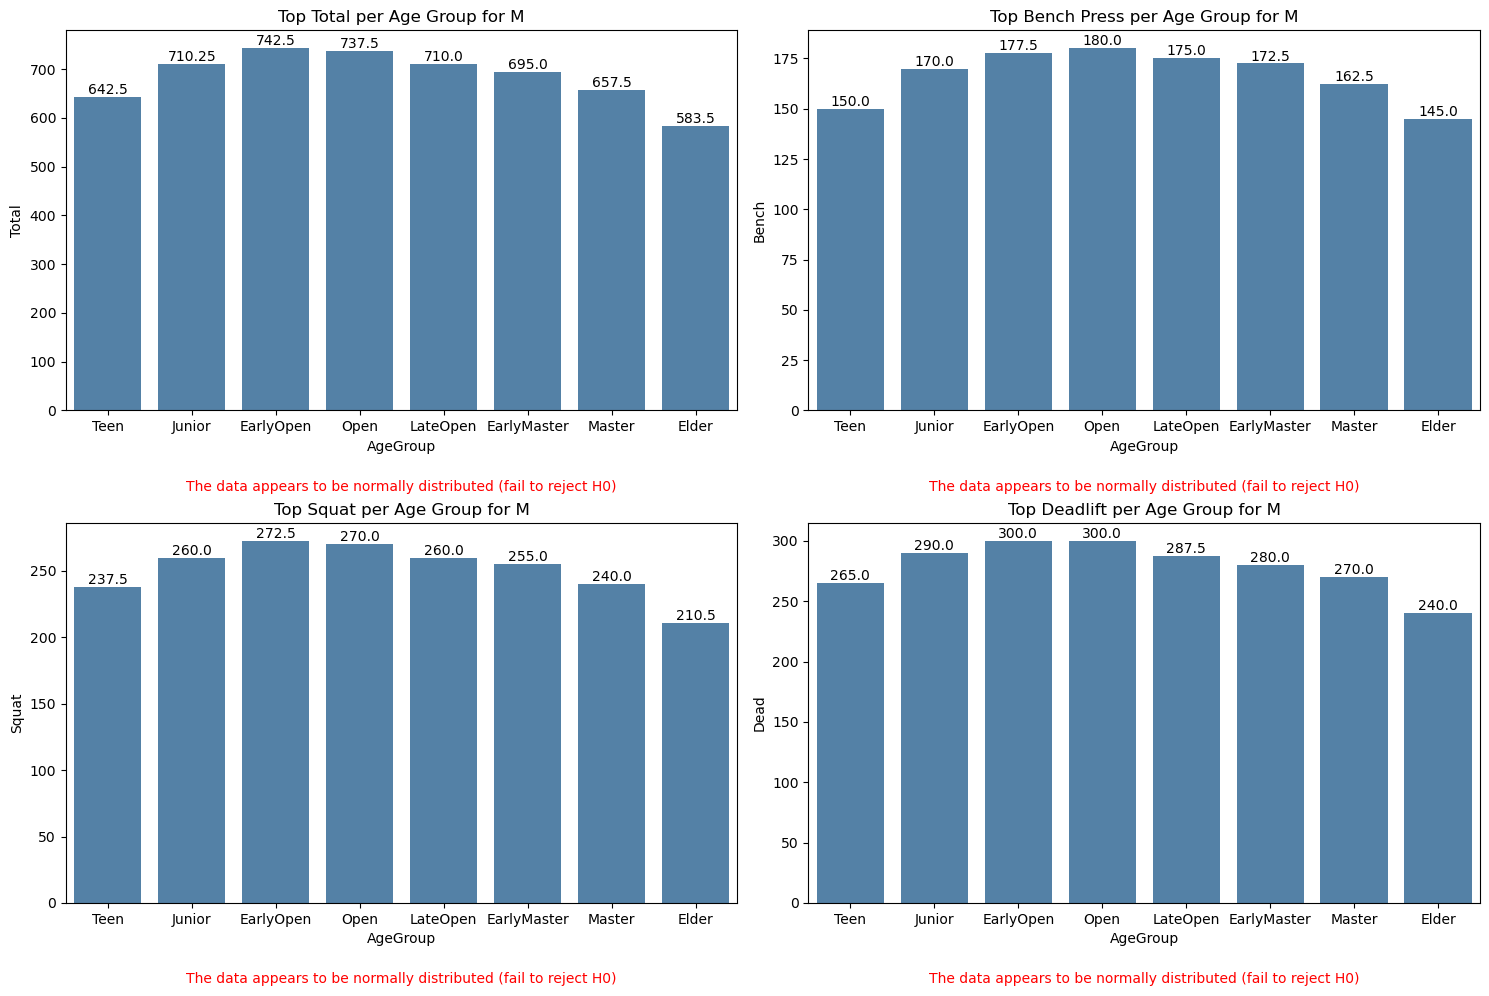

In [30]:
bar_quadrant(total[total['Weight']=='Heavy'],bench[bench['Weight']=='Heavy'],
             squat[squat['Weight']=='Heavy'],dead[dead['Weight']=='Heavy'],'M')

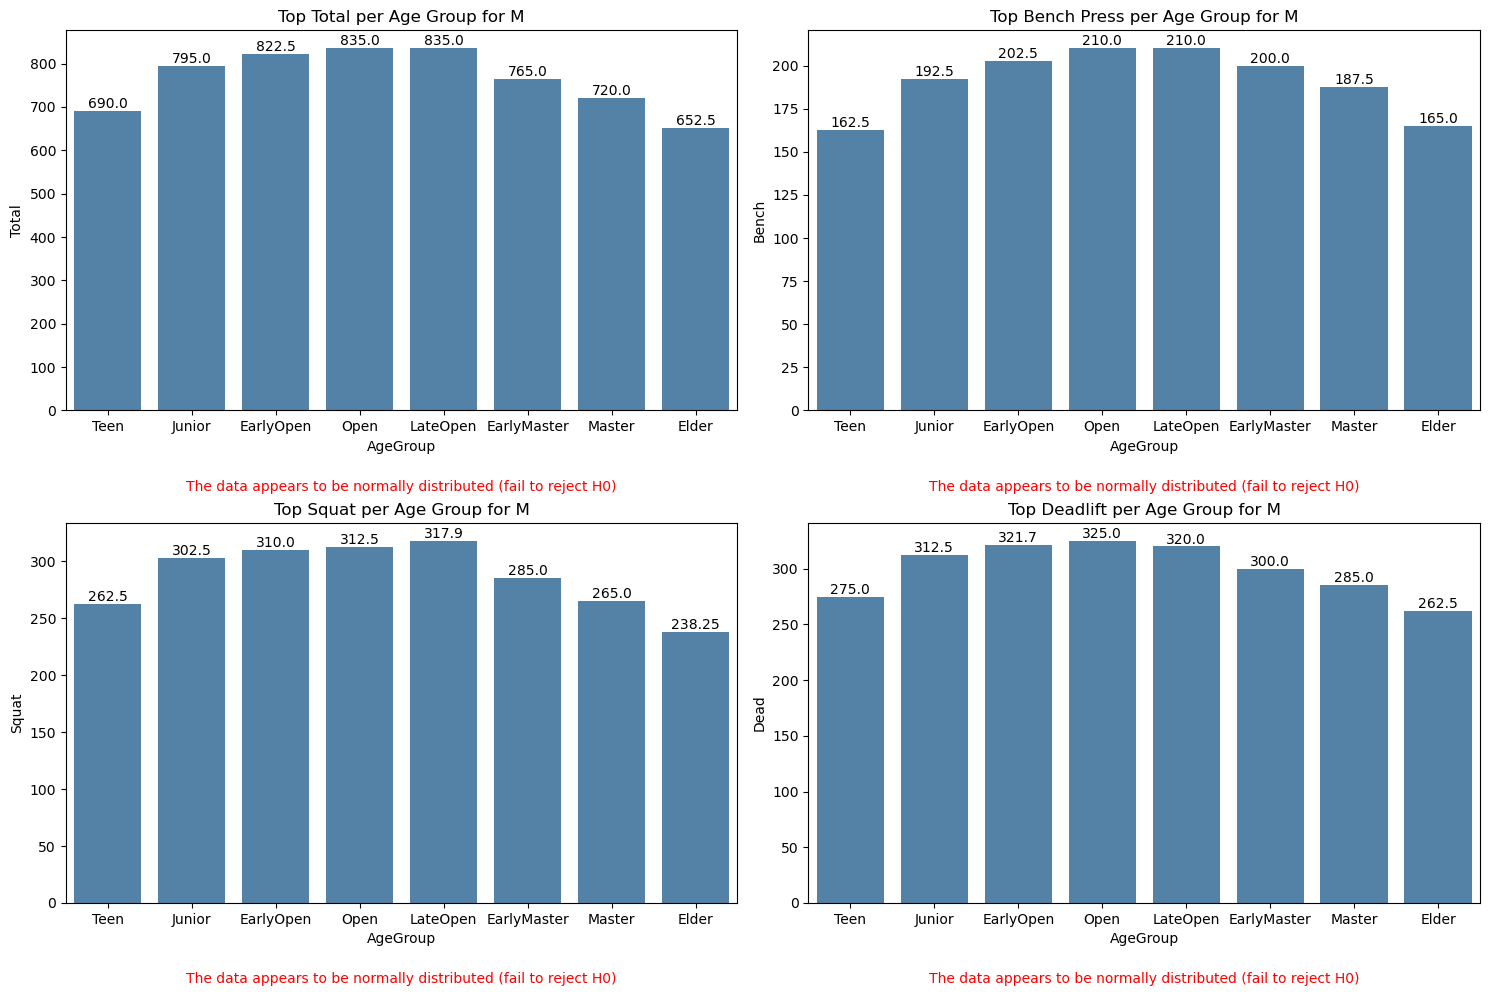

In [31]:
bar_quadrant(total[total['Weight']=='SuperHeavy'],bench[bench['Weight']=='SuperHeavy'],
             squat[squat['Weight']=='SuperHeavy'],dead[dead['Weight']=='SuperHeavy'],'M')

# 2) Peak Strength Statistical Testing

Top 10% of Total, Bench, Dead, and Squat for each Weight Group
- Statistical testing for difference in mean strength in the top lifters per each weight class, compared by age
    - I.e., After taking the top lifters in each weight class, is there a difference in mean strength between the age groups.

In [32]:
def max_strength_df(total, sex):
    summary = pd.DataFrame()
    col = total.columns[2]
    cutoff = total[total['Sex'] == sex].groupby('Weight')[col].quantile(.9).reset_index().copy()
    for x in range(len(cutoff)):
        weight = cutoff.iloc[x,0]
        strength = cutoff.iloc[x,1]
        df = total[total['Sex'] == sex][(total[total['Sex'] == sex]['Weight']==weight)&(total[total['Sex'] == sex][col]>=strength)].copy()
        summary = pd.concat([summary, df], axis = 0, ignore_index = True)
    return summary

def mean_strength_difference(total, sex, alpha):
    total_test = max_strength_df(total,sex)
    col = total_test.columns[2]
    pvals = []
    for group in total_test['AgeGroup'].unique():
        sample = total_test[total_test['AgeGroup']==group][col].copy()
        if len(sample) > 5000:
            pvals.append(pd.DataFrame([group,stats.kstest(sample,'norm')[1],sample.mean()]).T)
        else:
            pvals.append(pd.DataFrame([group,stats.shapiro(sample)[1],sample.mean()]).T)
    normality_test = pd.concat(pvals,ignore_index = True)
    normality_test.columns = ['AgeGroup','p-value','Mean']
    print('Normal Distribution Testing: ')
    print(normality_test)
    if (normality_test['p-value'] < alpha).sum() > 0:
        print('\nNon Normal, using Kruskal-Wallis')
        mean_test_result = stats.kruskal(*[total_test.loc[total_test['AgeGroup'] == group, col] for group in total_test['AgeGroup'].unique()])[1]
        print(mean_test_result)
        if mean_test_result < alpha:
            print('The mean strength is significantly different between the age groups')
            # Define the groups
            age_groups = total_test['AgeGroup'].unique()

            # Initialize a dictionary to store the results
            results = {}

            # Perform pairwise Mann-Whitney U-tests
            for group1, group2 in combinations(age_groups, 2):
                u, p = stats.mannwhitneyu(total_test.loc[total_test['AgeGroup'] == group1, col], 
                                            total_test.loc[total_test['AgeGroup'] == group2, col])
                
                mean1 = np.mean(total_test.loc[total_test['AgeGroup'] == group1, col])
                mean2 = np.mean(total_test.loc[total_test['AgeGroup'] == group2, col])
                mean_diff = mean1 - mean2
                
                results[(group1, group2)] = {'p-value': p, 'mean_diff': mean_diff}

            # Apply Holm-Bonferroni correction
            p_values = [results[key]['p-value'] for key in results]
            sorted_p_values = sorted(p_values)
            adjusted_p_values = []
            for i, p in enumerate(sorted_p_values):
                adjusted_p = len(p_values) * p / (i + 1)
                adjusted_p_values.append(min(adjusted_p, 1))

            # Store the adjusted p-values in the results dictionary
            for i, key in enumerate(results):
                results[key]['p-value'] = adjusted_p_values[i]

            # Print the results
            print()
            for key, value in results.items():
                print(f"Comparison: {key[0]} vs {key[1]}, Mean Difference: {value['mean_diff']}, Adjusted p-value: {value['p-value']}")
        else:
            print('The mean strength is not significantly different between the age groups')

    else:
        print('\nNormal, using F test')
        mean_test_result = stats.f_oneway(*[total_test.loc[total_test['AgeGroup'] == group, col] for group in total_test['AgeGroup'].unique()])[1]
        print(mean_test_result)
        if mean_test_result < alpha:
            print('The mean strength is significantly different between the age groups')
            # Perform Tukey's HSD test
            tukey = pairwise_tukeyhsd(endog=total_test[col], groups= total_test['AgeGroup'], alpha=0.05)

            # Print the results
            print()
            print(tukey)
        else:
            print('The mean strength is not significantly different between the age groups')


Null hypothesis: The mean strength of the top lifters is the same for all AgeGroups

Sex = M

In [33]:
mean_strength_difference(total,'M',.05)

Normal Distribution Testing: 
      AgeGroup   p-value        Mean
0    EarlyOpen       0.0  725.388895
1  EarlyMaster  0.000051  726.915179
2         Open       0.0  735.720786
3       Junior       0.0  703.027623
4       Master  0.000007  719.633065
5     LateOpen  0.000042    753.3125
6         Teen       0.0  669.094262
7        Elder  0.002692  731.088235

Non Normal, using Kruskal-Wallis
1.115190019676772e-128
The mean strength is significantly different between the age groups

Comparison: EarlyOpen vs EarlyMaster, Mean Difference: -1.526283794744245, Adjusted p-value: 1.6686175764059242e-66
Comparison: EarlyOpen vs Open, Mean Difference: -10.331891677275962, Adjusted p-value: 1.5708215108104237e-62
Comparison: EarlyOpen vs Junior, Mean Difference: 22.361271749757634, Adjusted p-value: 1.6131078446185387e-54
Comparison: EarlyOpen vs Master, Mean Difference: 5.755830260555285, Adjusted p-value: 7.180787604951595e-54
Comparison: EarlyOpen vs LateOpen, Mean Difference: -27.923605223

In [34]:
mean_strength_difference(squat,'M',.05)

Normal Distribution Testing: 
      AgeGroup   p-value        Mean
0    EarlyOpen       0.0  266.210921
1         Open       0.0   269.89237
2  EarlyMaster  0.000004  265.999053
3       Junior       0.0  258.704579
4         Teen       0.0  245.268977
5       Master  0.000545  266.552189
6     LateOpen       0.0  278.594599
7        Elder  0.432174     261.875

Non Normal, using Kruskal-Wallis
3.371796366987581e-120
The mean strength is significantly different between the age groups

Comparison: EarlyOpen vs Open, Mean Difference: -3.681449776868135, Adjusted p-value: 7.573498363020743e-72
Comparison: EarlyOpen vs EarlyMaster, Mean Difference: 0.21186750187968073, Adjusted p-value: 1.0519933713336313e-60
Comparison: EarlyOpen vs Junior, Mean Difference: 7.5063410355589895, Adjusted p-value: 2.0579476441236842e-58
Comparison: EarlyOpen vs Teen, Mean Difference: 20.9419436344929, Adjusted p-value: 1.9409283836348345e-47
Comparison: EarlyOpen vs Master, Mean Difference: -0.341268020005884

In [35]:
mean_strength_difference(dead,'M',.05)

Normal Distribution Testing: 
      AgeGroup   p-value        Mean
0    EarlyOpen       0.0   295.79451
1         Open       0.0   298.04694
2       Junior       0.0  288.295903
3       Master   0.00052  288.565292
4     LateOpen  0.000093  301.953212
5         Teen       0.0  273.458946
6        Elder  0.030626  269.666667
7  EarlyMaster  0.000001  294.337264

Non Normal, using Kruskal-Wallis
9.096991671840012e-138
The mean strength is significantly different between the age groups

Comparison: EarlyOpen vs Open, Mean Difference: -2.2524302837029495, Adjusted p-value: 1.4243888296253433e-88
Comparison: EarlyOpen vs Junior, Mean Difference: 7.498607206097347, Adjusted p-value: 2.4808775776298256e-82
Comparison: EarlyOpen vs Master, Mean Difference: 7.229217960986205, Adjusted p-value: 2.903918674128017e-62
Comparison: EarlyOpen vs LateOpen, Mean Difference: -6.158702233296651, Adjusted p-value: 2.3780209735619505e-44
Comparison: EarlyOpen vs Teen, Mean Difference: 22.335563978774758, A

Sex = F

In [36]:
mean_strength_difference(total,'F',.05)

Normal Distribution Testing: 
      AgeGroup   p-value        Mean
0    EarlyOpen       0.0  445.849103
1         Open       0.0  450.356388
2       Master  0.023422  449.518587
3     LateOpen       0.0  448.712171
4       Junior       0.0  438.335823
5         Teen       0.0  441.002042
6  EarlyMaster  0.000028  442.877551
7        Elder  0.022856  431.119048

Non Normal, using Kruskal-Wallis
6.386741271849542e-09
The mean strength is significantly different between the age groups

Comparison: EarlyOpen vs Open, Mean Difference: -4.507285115089871, Adjusted p-value: 4.396216340741174e-08
Comparison: EarlyOpen vs Master, Mean Difference: -3.6694841457047573, Adjusted p-value: 0.00019359952658230925
Comparison: EarlyOpen vs LateOpen, Mean Difference: -2.8630678377415393, Adjusted p-value: 0.0004951249054578037
Comparison: EarlyOpen vs Junior, Mean Difference: 7.51328036087142, Adjusted p-value: 0.0005256113194449776
Comparison: EarlyOpen vs Teen, Mean Difference: 4.847061172847987, Adju

In [37]:
mean_strength_difference(squat,'F',.05)

Normal Distribution Testing: 
      AgeGroup   p-value        Mean
0    EarlyOpen       0.0  166.332449
1         Open       0.0  168.575632
2       Master  0.002892  167.098039
3     LateOpen       0.0     168.625
4       Junior       0.0  162.967955
5         Teen       0.0  165.708703
6  EarlyMaster   0.00019  165.116919
7        Elder  0.161198  157.884615

Non Normal, using Kruskal-Wallis
9.571849263240406e-12
The mean strength is significantly different between the age groups

Comparison: EarlyOpen vs Open, Mean Difference: -2.2431826938842505, Adjusted p-value: 9.203541354703282e-11
Comparison: EarlyOpen vs Master, Mean Difference: -0.7655898387392313, Adjusted p-value: 2.1941859885937532e-06
Comparison: EarlyOpen vs LateOpen, Mean Difference: -2.2925506230529606, Adjusted p-value: 0.00010841086838972956
Comparison: EarlyOpen vs Junior, Mean Difference: 3.364494090500841, Adjusted p-value: 0.0014547826485726083
Comparison: EarlyOpen vs Teen, Mean Difference: 0.6237467821366636, 

In [38]:
mean_strength_difference(bench,'F',.05)

Normal Distribution Testing: 
      AgeGroup   p-value       Mean
0    EarlyOpen       0.0  96.322932
1         Open       0.0  98.620301
2       Master  0.000002  99.806011
3       Junior       0.0  95.730955
4         Teen       0.0  95.821485
5  EarlyMaster       0.0  96.030162
6     LateOpen       0.0  97.775621
7        Elder  0.001896  93.589744

Non Normal, using Kruskal-Wallis
2.219159878788019e-12
The mean strength is significantly different between the age groups

Comparison: EarlyOpen vs Open, Mean Difference: -2.2973687289476743, Adjusted p-value: 2.688492651227378e-08
Comparison: EarlyOpen vs Master, Mean Difference: -3.483078906029732, Adjusted p-value: 2.830412217676982e-08
Comparison: EarlyOpen vs Junior, Mean Difference: 0.591977274050862, Adjusted p-value: 4.945050647173346e-06
Comparison: EarlyOpen vs Teen, Mean Difference: 0.5014471041385207, Adjusted p-value: 4.892488763572977e-06
Comparison: EarlyOpen vs EarlyMaster, Mean Difference: 0.29276960993898626, Adjusted 

In [39]:
mean_strength_difference(dead,'F',.05)

Normal Distribution Testing: 
      AgeGroup   p-value        Mean
0    EarlyOpen       0.0  188.845889
1     LateOpen  0.000001  188.747143
2         Open       0.0  190.985912
3       Master       0.0  187.577586
4       Junior       0.0  185.785753
5         Teen  0.000402   183.19697
6  EarlyMaster       0.0  189.163597
7        Elder  0.365752  185.474359

Non Normal, using Kruskal-Wallis
2.4700948366121596e-14
The mean strength is significantly different between the age groups

Comparison: EarlyOpen vs LateOpen, Mean Difference: 0.09874612113551962, Adjusted p-value: 8.255980460138356e-13
Comparison: EarlyOpen vs Open, Mean Difference: -2.1400230335852086, Adjusted p-value: 9.103959229751074e-08
Comparison: EarlyOpen vs Master, Mean Difference: 1.2683027713818262, Adjusted p-value: 0.00030759475270349384
Comparison: EarlyOpen vs Junior, Mean Difference: 3.0601355536208246, Adjusted p-value: 0.00044569706960623484
Comparison: EarlyOpen vs Teen, Mean Difference: 5.648919281308679, 

Null hypothesis: The mean Age of the top lifters is the same for all Weight classes

In [40]:
def mean_age_difference(total, sex, alpha):
    total_test = max_strength_df(total,sex)
    col = 'Age'
    pvals = []
    for group in total_test['Weight'].unique():
        sample = total_test[total_test['Weight']==group][col].copy()
        if len(sample) > 5000:
            pvals.append(pd.DataFrame([group,stats.kstest(sample,'norm')[1],sample.mean()]).T)
        else:
            pvals.append(pd.DataFrame([group,stats.shapiro(sample)[1],sample.mean()]).T)
    normality_test = pd.concat(pvals,ignore_index = True)
    normality_test.columns = ['Weight','p-value','Mean']
    print('Normal Distribution Testing: ')
    print(normality_test)
    if (normality_test['p-value'] < alpha).sum() > 0:
        print('\nNon Normal, using Kruskal-Wallis')
        mean_test_result = stats.kruskal(*[total_test.loc[total_test['Weight'] == group, col] for group in total_test['Weight'].unique()])[1]
        print(mean_test_result)
        if mean_test_result < alpha:
            print('The mean age is significantly different between the weight groups')
            # Define the groups
            age_groups = total_test['Weight'].unique()

            # Initialize a dictionary to store the results
            results = {}

            # Perform pairwise Mann-Whitney U-tests
            for group1, group2 in combinations(age_groups, 2):
                u, p = stats.mannwhitneyu(total_test.loc[total_test['Weight'] == group1, col], 
                                            total_test.loc[total_test['Weight'] == group2, col])
                
                mean1 = np.mean(total_test.loc[total_test['Weight'] == group1, col])
                mean2 = np.mean(total_test.loc[total_test['Weight'] == group2, col])
                mean_diff = mean1 - mean2
                
                results[(group1, group2)] = {'p-value': p, 'mean_diff': mean_diff}

            # Apply Holm-Bonferroni correction
            p_values = [results[key]['p-value'] for key in results]
            sorted_p_values = sorted(p_values)
            adjusted_p_values = []
            for i, p in enumerate(sorted_p_values):
                adjusted_p = len(p_values) * p / (i + 1)
                adjusted_p_values.append(min(adjusted_p, 1))

            # Store the adjusted p-values in the results dictionary
            for i, key in enumerate(results):
                results[key]['p-value'] = adjusted_p_values[i]

            # Print the results
            print()
            for key, value in results.items():
                print(f"Comparison: {key[0]} vs {key[1]}, Mean Difference: {value['mean_diff']}, Adjusted p-value: {value['p-value']}")
        else:
            print('The mean age is not significantly different between the weight groups')

    else:
        print('\nNormal, using F test')
        mean_test_result = stats.f_oneway(*[total_test.loc[total_test['Weight'] == group, col] for group in total_test['Weight'].unique()])[1]
        print(mean_test_result)
        if mean_test_result < alpha:
            print('The mean age is significantly different between the weight groups')
            # Perform Tukey's HSD test
            tukey = pairwise_tukeyhsd(endog=total_test[col], groups= total_test['Weight'], alpha=0.05)

            # Print the results
            print()
            print(tukey)
        else:
            print('The mean age is not significantly different between the weight groups')


Sex = M

In [41]:
mean_age_difference(total,'M',.05)

Normal Distribution Testing: 
       Weight p-value       Mean
0       Light     0.0  25.567179
1      Middle     0.0  25.782834
2       Heavy     0.0  26.745503
3  SuperHeavy     0.0  28.706544

Non Normal, using Kruskal-Wallis
2.66981955057548e-98
The mean age is significantly different between the weight groups

Comparison: Light vs Middle, Mean Difference: -0.21565430028645238, Adjusted p-value: 1.5437459556819059e-77
Comparison: Light vs Heavy, Mean Difference: -1.1783233396150976, Adjusted p-value: 5.617912179427881e-66
Comparison: Light vs SuperHeavy, Mean Difference: -3.139364480100678, Adjusted p-value: 3.4904671960338062e-37
Comparison: Middle vs Heavy, Mean Difference: -0.9626690393286452, Adjusted p-value: 9.14190784904775e-23
Comparison: Middle vs SuperHeavy, Mean Difference: -2.9237101798142255, Adjusted p-value: 4.776282966965246e-22
Comparison: Heavy vs SuperHeavy, Mean Difference: -1.9610411404855803, Adjusted p-value: 0.0019481975845973406


In [42]:
mean_age_difference(squat,'M',.05)

Normal Distribution Testing: 
       Weight p-value       Mean
0       Light     0.0  25.359961
1      Middle     0.0  25.629945
2       Heavy     0.0  26.639214
3  SuperHeavy     0.0  28.380866

Non Normal, using Kruskal-Wallis
9.422163677671075e-94
The mean age is significantly different between the weight groups

Comparison: Light vs Middle, Mean Difference: -0.26998482101432586, Adjusted p-value: 1.5270293086623363e-72
Comparison: Light vs Heavy, Mean Difference: -1.279253298925017, Adjusted p-value: 9.135557485829592e-60
Comparison: Light vs SuperHeavy, Mean Difference: -3.0209058737245336, Adjusted p-value: 4.228593550902015e-31
Comparison: Middle vs Heavy, Mean Difference: -1.009268477910691, Adjusted p-value: 2.0058842032300958e-24
Comparison: Middle vs SuperHeavy, Mean Difference: -2.7509210527102077, Adjusted p-value: 1.4130123123800718e-23
Comparison: Heavy vs SuperHeavy, Mean Difference: -1.7416525747995166, Adjusted p-value: 0.0016106397125475388


In [43]:
mean_age_difference(bench,'M',.05)

Normal Distribution Testing: 
       Weight p-value       Mean
0       Light     0.0  26.103104
1      Middle     0.0  26.267852
2       Heavy     0.0  27.870552
3  SuperHeavy     0.0  30.505785

Non Normal, using Kruskal-Wallis
2.062369666912159e-166
The mean age is significantly different between the weight groups

Comparison: Light vs Middle, Mean Difference: -0.16474824404046373, Adjusted p-value: 2.1598294334176284e-134
Comparison: Light vs Heavy, Mean Difference: -1.767447896727088, Adjusted p-value: 2.2386853141478215e-94
Comparison: Light vs SuperHeavy, Mean Difference: -4.402681078580901, Adjusted p-value: 2.710540797972601e-53
Comparison: Middle vs Heavy, Mean Difference: -1.6026996526866242, Adjusted p-value: 4.9140397877939105e-48
Comparison: Middle vs SuperHeavy, Mean Difference: -4.2379328345404375, Adjusted p-value: 1.8830926695218074e-32
Comparison: Heavy vs SuperHeavy, Mean Difference: -2.6352331818538133, Adjusted p-value: 0.010417717326841726


Sex = F

In [44]:
mean_age_difference(total,'F',.05)

Normal Distribution Testing: 
       Weight p-value       Mean
0       Light     0.0  28.063477
1      Middle     0.0  27.243565
2       Heavy     0.0  28.054797
3  SuperHeavy     0.0  29.952014

Non Normal, using Kruskal-Wallis
6.732404713308427e-15
The mean age is significantly different between the weight groups

Comparison: Light vs Middle, Mean Difference: 0.8199110818035571, Adjusted p-value: 1.4456395187629574e-14
Comparison: Light vs Heavy, Mean Difference: 0.008679962621432225, Adjusted p-value: 5.466388528832849e-08
Comparison: Light vs SuperHeavy, Mean Difference: -1.8885376555094773, Adjusted p-value: 4.531283977259674e-05
Comparison: Middle vs Heavy, Mean Difference: -0.8112311191821249, Adjusted p-value: 6.060859520390682e-05
Comparison: Middle vs SuperHeavy, Mean Difference: -2.7084487373130344, Adjusted p-value: 0.00018032846879924449
Comparison: Heavy vs SuperHeavy, Mean Difference: -1.8972176181309095, Adjusted p-value: 0.3721785015369689


In [45]:
mean_age_difference(squat,'F',.05)

Normal Distribution Testing: 
       Weight p-value       Mean
0       Light     0.0   27.56222
1      Middle     0.0  26.654086
2       Heavy     0.0  27.530851
3  SuperHeavy     0.0  28.441143

Non Normal, using Kruskal-Wallis
1.6992699216525367e-08
The mean age is significantly different between the weight groups

Comparison: Light vs Middle, Mean Difference: 0.9081344870719477, Adjusted p-value: 1.0388533720257049e-06
Comparison: Light vs Heavy, Mean Difference: 0.03136916893655339, Adjusted p-value: 5.001515639202335e-05
Comparison: Light vs SuperHeavy, Mean Difference: -0.8789226243765178, Adjusted p-value: 8.504524935699387e-05
Comparison: Middle vs Heavy, Mean Difference: -0.8767653181353943, Adjusted p-value: 0.007497926732514739
Comparison: Middle vs SuperHeavy, Mean Difference: -1.7870571114484655, Adjusted p-value: 0.1036801695546499
Comparison: Heavy vs SuperHeavy, Mean Difference: -0.9102917933130712, Adjusted p-value: 0.27308143481456837


In [46]:
mean_age_difference(bench,'F',.05)

Normal Distribution Testing: 
       Weight p-value       Mean
0       Light     0.0  27.739749
1      Middle     0.0  27.250263
2       Heavy     0.0  28.066897
3  SuperHeavy     0.0  31.354188

Non Normal, using Kruskal-Wallis
1.119714904070239e-37
The mean age is significantly different between the weight groups

Comparison: Light vs Middle, Mean Difference: 0.4894855187799543, Adjusted p-value: 1.2756287339828417e-37
Comparison: Light vs Heavy, Mean Difference: -0.3271482198074267, Adjusted p-value: 3.075011182588172e-26
Comparison: Light vs SuperHeavy, Mean Difference: -3.614438735227928, Adjusted p-value: 4.2494126254261635e-20
Comparison: Middle vs Heavy, Mean Difference: -0.816633738587381, Adjusted p-value: 9.935957852055043e-05
Comparison: Middle vs SuperHeavy, Mean Difference: -4.103924254007882, Adjusted p-value: 0.0026380531859074344
Comparison: Heavy vs SuperHeavy, Mean Difference: -3.2872905154205014, Adjusted p-value: 0.9209709894408079


In [47]:
mean_age_difference(dead,'F',.05)

Normal Distribution Testing: 
       Weight p-value       Mean
0       Light     0.0  28.298422
1      Middle     0.0  27.868292
2       Heavy     0.0  28.625311
3  SuperHeavy     0.0  30.678107

Non Normal, using Kruskal-Wallis
4.98052946063539e-19
The mean age is significantly different between the weight groups

Comparison: Light vs Middle, Mean Difference: 0.43013067531034466, Adjusted p-value: 1.6124123592795486e-19
Comparison: Light vs Heavy, Mean Difference: -0.3268884228941644, Adjusted p-value: 3.64092769662167e-12
Comparison: Light vs SuperHeavy, Mean Difference: -2.3796840724164916, Adjusted p-value: 4.2750044754155626e-10
Comparison: Middle vs Heavy, Mean Difference: -0.7570190982045091, Adjusted p-value: 7.323930426195676e-05
Comparison: Middle vs SuperHeavy, Mean Difference: -2.8098147477268363, Adjusted p-value: 0.021287645176522662
Comparison: Heavy vs SuperHeavy, Mean Difference: -2.052795649522327, Adjusted p-value: 0.5845732734689398


Total Weight Lifted

Null Hypothesis: The mean Age of the top lifters in each Weight Group are the same across Sex.

In [48]:
def mean_age_difference(total,alpha):
    df1 = max_strength_df(total, 'M')
    df2 = max_strength_df(total,'F')

    weight_groups = df['Weight'].unique()
    for weight in weight_groups:
        print('Weight: '+weight)
        sample1 = df1[df1['Weight']==weight]['Age'].copy()
        sample2 = df2[df2['Weight']==weight]['Age'].copy()
        print('Mean Age M: '+str(sample1.mean()))
        print('Mean Age F: '+str(sample2.mean()))
        if (len(sample1) <5000) & (len(sample2) <5000):
            norm1 = stats.shapiro(sample1)[1]
            norm2 = stats.shapiro(sample2)[1]

        else:
            norm1 = stats.kstest(sample1,'norm')[1]
            norm2 = stats.kstest(sample2,'norm')[1]

        if (norm1 > alpha) & (norm2 > alpha):
            print('Normal, t-test')
            result = stats.ttest_ind(sample1,sample2)[1]

        else:
            print('Non Normal, Mann-Whitney U')
            result = stats.mannwhitneyu(sample1,sample2)[1]
            
        print(result)
        if result < alpha:
            print('The mean age is significantly different between the sex groups')
        else:
            print('The mean age is not significantly different between the sex groups')


In [49]:
mean_age_difference(total,.05)

Weight: Heavy
Mean Age M: 26.745502826794585
Mean Age F: 28.054796599878568
Non Normal, Mann-Whitney U
2.876102698177649e-12
The mean age is significantly different between the sex groups
Weight: Middle
Mean Age M: 25.78283378746594
Mean Age F: 27.243565480696443
Non Normal, Mann-Whitney U
2.5046830693201402e-18
The mean age is significantly different between the sex groups
Weight: Light
Mean Age M: 25.567179487179487
Mean Age F: 28.0634765625
Non Normal, Mann-Whitney U
1.863959427874741e-26
The mean age is significantly different between the sex groups
Weight: SuperHeavy
Mean Age M: 28.706543967280165
Mean Age F: 29.952014218009477
Non Normal, Mann-Whitney U
0.017775511494596802
The mean age is significantly different between the sex groups


In [50]:
mean_age_difference(squat,.05)

Weight: Heavy
Mean Age M: 26.63921385119326
Mean Age F: 27.530851063829786
Non Normal, Mann-Whitney U
1.255038984182252e-06
The mean age is significantly different between the sex groups
Weight: Middle
Mean Age M: 25.62994537328257
Mean Age F: 26.654085745694392
Non Normal, Mann-Whitney U
3.1631408066150448e-12
The mean age is significantly different between the sex groups
Weight: Light
Mean Age M: 25.359960552268245
Mean Age F: 27.56222023276634
Non Normal, Mann-Whitney U
7.510053331499316e-23
The mean age is significantly different between the sex groups
Weight: SuperHeavy
Mean Age M: 28.380866425992778
Mean Age F: 28.441142857142857
Non Normal, Mann-Whitney U
0.32225235069591807
The mean age is not significantly different between the sex groups


In [51]:
mean_age_difference(bench,.05)

Weight: Heavy
Mean Age M: 27.870551526395683
Mean Age F: 28.066897173782323
Non Normal, Mann-Whitney U
0.2705978443937542
The mean age is not significantly different between the sex groups
Weight: Middle
Mean Age M: 26.26785187370906
Mean Age F: 27.25026343519494
Non Normal, Mann-Whitney U
3.361765429988486e-07
The mean age is significantly different between the sex groups
Weight: Light
Mean Age M: 26.103103629668595
Mean Age F: 27.739748953974896
Non Normal, Mann-Whitney U
3.9605491652527583e-14
The mean age is significantly different between the sex groups
Weight: SuperHeavy
Mean Age M: 30.505784708249497
Mean Age F: 31.354187689202824
Non Normal, Mann-Whitney U
0.16440025874094188
The mean age is not significantly different between the sex groups


In [52]:
mean_age_difference(dead,.05)

Weight: Heavy
Mean Age M: 26.541905082463817
Mean Age F: 28.625310859353412
Non Normal, Mann-Whitney U
1.6870442725692526e-32
The mean age is significantly different between the sex groups
Weight: Middle
Mean Age M: 25.598069631161668
Mean Age F: 27.868291761148903
Non Normal, Mann-Whitney U
1.7571783459125825e-39
The mean age is significantly different between the sex groups
Weight: Light
Mean Age M: 25.304552201880256
Mean Age F: 28.298422436459248
Non Normal, Mann-Whitney U
2.1085417574469863e-36
The mean age is significantly different between the sex groups
Weight: SuperHeavy
Mean Age M: 28.08508691674291
Mean Age F: 30.67810650887574
Non Normal, Mann-Whitney U
2.730726311530016e-13
The mean age is significantly different between the sex groups


# 3) Peak Age Linear Regression Testing

Exploring the relationship leading up to and after the Peak Age per Weight Group for top strength levels

In [102]:
def pre_peak_lin(total,sex):
    aa = max_strength_df(total,sex)
    a = aa.groupby('Weight')['Age'].describe()[['mean','std']]
    col = aa.columns[2]

    a['high'] = a['mean']+(a['std']*.75) # add .75 * SD for buffer in peak age
    results = {}
    for x in range(len(a)):
        weight = a.index[x]
        high = a.iloc[x,2]
        high_df = aa[(aa['Weight']== a.index[x])&(aa['Age']<=high)].copy()
        high_r = stats.linregress(high_df['Age'],high_df[col])
        results[f'{col} and Age Pre-Peak Age for {weight} {sex}'] = {'Before Peak-Age':round(high,2),
                                                                     'Slope':round(stats.linregress(high_df['Age'],high_df[col])[0],2),
                                                                'p-value':'{:.5f}'.format(stats.linregress(high_df['Age'],high_df[col])[3]),
                                                                'R':round(stats.linregress(high_df['Age'],high_df[col])[2],2)}
    return results

Null Hypothesis: The slope of the linear relationship between Age and Strength is 0 for top lifters leading up to Peak Age

Sex: M

In [103]:
pre_peak_lin(total,'M')

{'Total and Age Pre-Peak Age for Light M': {'Before Peak-Age': 30.32,
  'Slope': 2.41,
  'p-value': '0.00000',
  'R': 0.22},
 'Total and Age Pre-Peak Age for Middle M': {'Before Peak-Age': 30.19,
  'Slope': 1.93,
  'p-value': '0.00000',
  'R': 0.16},
 'Total and Age Pre-Peak Age for Heavy M': {'Before Peak-Age': 31.36,
  'Slope': 1.28,
  'p-value': '0.00000',
  'R': 0.1},
 'Total and Age Pre-Peak Age for SuperHeavy M': {'Before Peak-Age': 33.61,
  'Slope': 0.48,
  'p-value': '0.13095',
  'R': 0.04}}

In [104]:
pre_peak_lin(squat,'M')

{'Squat and Age Pre-Peak Age for Light M': {'Before Peak-Age': 30.31,
  'Slope': 0.91,
  'p-value': '0.00000',
  'R': 0.23},
 'Squat and Age Pre-Peak Age for Middle M': {'Before Peak-Age': 30.28,
  'Slope': 0.67,
  'p-value': '0.00000',
  'R': 0.14},
 'Squat and Age Pre-Peak Age for Heavy M': {'Before Peak-Age': 31.49,
  'Slope': 0.43,
  'p-value': '0.00000',
  'R': 0.08},
 'Squat and Age Pre-Peak Age for SuperHeavy M': {'Before Peak-Age': 33.5,
  'Slope': 0.09,
  'p-value': '0.49535',
  'R': 0.02}}

In [105]:
pre_peak_lin(bench,'M')

{'Bench and Age Pre-Peak Age for Light M': {'Before Peak-Age': 31.32,
  'Slope': 0.61,
  'p-value': '0.00000',
  'R': 0.2},
 'Bench and Age Pre-Peak Age for Middle M': {'Before Peak-Age': 31.19,
  'Slope': 0.4,
  'p-value': '0.00000',
  'R': 0.12},
 'Bench and Age Pre-Peak Age for Heavy M': {'Before Peak-Age': 33.25,
  'Slope': 0.37,
  'p-value': '0.00000',
  'R': 0.12},
 'Bench and Age Pre-Peak Age for SuperHeavy M': {'Before Peak-Age': 36.07,
  'Slope': 0.15,
  'p-value': '0.06361',
  'R': 0.05}}

In [106]:
pre_peak_lin(dead,'M')

{'Dead and Age Pre-Peak Age for Light M': {'Before Peak-Age': 30.46,
  'Slope': 0.96,
  'p-value': '0.00000',
  'R': 0.21},
 'Dead and Age Pre-Peak Age for Middle M': {'Before Peak-Age': 30.22,
  'Slope': 0.63,
  'p-value': '0.00000',
  'R': 0.12},
 'Dead and Age Pre-Peak Age for Heavy M': {'Before Peak-Age': 31.22,
  'Slope': 0.53,
  'p-value': '0.00000',
  'R': 0.1},
 'Dead and Age Pre-Peak Age for SuperHeavy M': {'Before Peak-Age': 32.91,
  'Slope': 0.45,
  'p-value': '0.00009',
  'R': 0.09}}

Sex: F

In [107]:
pre_peak_lin(total,'F')

{'Total and Age Pre-Peak Age for Light F': {'Before Peak-Age': 33.24,
  'Slope': 1.46,
  'p-value': '0.00000',
  'R': 0.23},
 'Total and Age Pre-Peak Age for Middle F': {'Before Peak-Age': 32.4,
  'Slope': 0.85,
  'p-value': '0.00000',
  'R': 0.11},
 'Total and Age Pre-Peak Age for Heavy F': {'Before Peak-Age': 33.58,
  'Slope': 0.62,
  'p-value': '0.00033',
  'R': 0.07},
 'Total and Age Pre-Peak Age for SuperHeavy F': {'Before Peak-Age': 36.52,
  'Slope': 1.36,
  'p-value': '0.00073',
  'R': 0.13}}

In [108]:
pre_peak_lin(squat,'F')

{'Squat and Age Pre-Peak Age for Light F': {'Before Peak-Age': 32.72,
  'Slope': 0.47,
  'p-value': '0.00000',
  'R': 0.18},
 'Squat and Age Pre-Peak Age for Middle F': {'Before Peak-Age': 31.65,
  'Slope': 0.46,
  'p-value': '0.00000',
  'R': 0.14},
 'Squat and Age Pre-Peak Age for Heavy F': {'Before Peak-Age': 33.05,
  'Slope': 0.47,
  'p-value': '0.00000',
  'R': 0.14},
 'Squat and Age Pre-Peak Age for SuperHeavy F': {'Before Peak-Age': 34.64,
  'Slope': 0.73,
  'p-value': '0.00004',
  'R': 0.16}}

In [109]:
pre_peak_lin(bench,'F')

{'Bench and Age Pre-Peak Age for Light F': {'Before Peak-Age': 33.07,
  'Slope': 0.14,
  'p-value': '0.02060',
  'R': 0.07},
 'Bench and Age Pre-Peak Age for Middle F': {'Before Peak-Age': 32.8,
  'Slope': 0.21,
  'p-value': '0.00001',
  'R': 0.09},
 'Bench and Age Pre-Peak Age for Heavy F': {'Before Peak-Age': 34.02,
  'Slope': 0.01,
  'p-value': '0.81928',
  'R': 0.0},
 'Bench and Age Pre-Peak Age for SuperHeavy F': {'Before Peak-Age': 38.27,
  'Slope': 0.18,
  'p-value': '0.07667',
  'R': 0.06}}

In [110]:
pre_peak_lin(dead,'F')

{'Dead and Age Pre-Peak Age for Light F': {'Before Peak-Age': 33.87,
  'Slope': 0.88,
  'p-value': '0.00000',
  'R': 0.3},
 'Dead and Age Pre-Peak Age for Middle F': {'Before Peak-Age': 33.56,
  'Slope': 0.3,
  'p-value': '0.00001',
  'R': 0.1},
 'Dead and Age Pre-Peak Age for Heavy F': {'Before Peak-Age': 34.57,
  'Slope': 0.24,
  'p-value': '0.00019',
  'R': 0.07},
 'Dead and Age Pre-Peak Age for SuperHeavy F': {'Before Peak-Age': 37.17,
  'Slope': 0.4,
  'p-value': '0.00226',
  'R': 0.12}}

Null Hypothesis: The slope of the linear relationship between Age and Strength is 0 for top lifters after Peak Age

In [123]:
def post_peak_lin(total,sex):
    aa = max_strength_df(total,sex)
    a = aa.groupby('Weight')['Age'].describe()[['mean','std']]
    col = aa.columns[2]
    a['low'] = a['mean']+(a['std']*.75) # add .75 * SD for buffer in peak age
    results = {}
    for x in range(len(a)):
        weight = a.index[x]
        low = a.iloc[x,2]
        low_df = aa[(aa['Weight']== a.index[x])&(aa['Age']>=low)].copy()
        low_r = stats.linregress(low_df['Age'],low_df[col])
        results[f'{col} and Age Post-Peak Age for {weight} {sex}'] = {'After Peak-Age':round(low,2),
                                                                      'Slope':round(stats.linregress(low_df['Age'],low_df[col])[0],2),
                                                                'p-value':'{:.5f}'.format(stats.linregress(low_df['Age'],low_df[col])[3]),
                                                                'R':round(stats.linregress(low_df['Age'],low_df[col])[2],2)}
    return results

Sex: M

In [124]:
post_peak_lin(total,'M')

{'Total and Age Post-Peak Age for Light M': {'After Peak-Age': 30.32,
  'Slope': -1.56,
  'p-value': '0.00005',
  'R': -0.22},
 'Total and Age Post-Peak Age for Middle M': {'After Peak-Age': 30.19,
  'Slope': -1.1,
  'p-value': '0.00000',
  'R': -0.15},
 'Total and Age Post-Peak Age for Heavy M': {'After Peak-Age': 31.36,
  'Slope': -0.43,
  'p-value': '0.05441',
  'R': -0.06},
 'Total and Age Post-Peak Age for SuperHeavy M': {'After Peak-Age': 33.61,
  'Slope': -3.34,
  'p-value': '0.00000',
  'R': -0.29}}

In [125]:
post_peak_lin(squat,'M')

{'Squat and Age Post-Peak Age for Light M': {'After Peak-Age': 30.31,
  'Slope': -0.58,
  'p-value': '0.00009',
  'R': -0.21},
 'Squat and Age Post-Peak Age for Middle M': {'After Peak-Age': 30.28,
  'Slope': -0.49,
  'p-value': '0.00000',
  'R': -0.18},
 'Squat and Age Post-Peak Age for Heavy M': {'After Peak-Age': 31.49,
  'Slope': -0.24,
  'p-value': '0.00485',
  'R': -0.08},
 'Squat and Age Post-Peak Age for SuperHeavy M': {'After Peak-Age': 33.5,
  'Slope': -0.86,
  'p-value': '0.00263',
  'R': -0.14}}

In [126]:
post_peak_lin(bench,'M')

{'Bench and Age Post-Peak Age for Light M': {'After Peak-Age': 31.32,
  'Slope': -0.23,
  'p-value': '0.03118',
  'R': -0.12},
 'Bench and Age Post-Peak Age for Middle M': {'After Peak-Age': 31.19,
  'Slope': -0.31,
  'p-value': '0.00000',
  'R': -0.15},
 'Bench and Age Post-Peak Age for Heavy M': {'After Peak-Age': 33.25,
  'Slope': 0.03,
  'p-value': '0.58951',
  'R': 0.02},
 'Bench and Age Post-Peak Age for SuperHeavy M': {'After Peak-Age': 36.07,
  'Slope': -0.44,
  'p-value': '0.00460',
  'R': -0.14}}

In [127]:
post_peak_lin(dead,'M')

{'Dead and Age Post-Peak Age for Light M': {'After Peak-Age': 30.46,
  'Slope': -0.19,
  'p-value': '0.10115',
  'R': -0.09},
 'Dead and Age Post-Peak Age for Middle M': {'After Peak-Age': 30.22,
  'Slope': -0.34,
  'p-value': '0.00005',
  'R': -0.13},
 'Dead and Age Post-Peak Age for Heavy M': {'After Peak-Age': 31.22,
  'Slope': -0.35,
  'p-value': '0.00014',
  'R': -0.12},
 'Dead and Age Post-Peak Age for SuperHeavy M': {'After Peak-Age': 32.91,
  'Slope': -1.07,
  'p-value': '0.00000',
  'R': -0.27}}

Sex: F

In [128]:
post_peak_lin(total,'F')

{'Total and Age Post-Peak Age for Light F': {'After Peak-Age': 33.24,
  'Slope': -0.38,
  'p-value': '0.28148',
  'R': -0.08},
 'Total and Age Post-Peak Age for Middle F': {'After Peak-Age': 32.4,
  'Slope': -1.23,
  'p-value': '0.00000',
  'R': -0.22},
 'Total and Age Post-Peak Age for Heavy F': {'After Peak-Age': 33.58,
  'Slope': -1.07,
  'p-value': '0.00002',
  'R': -0.17},
 'Total and Age Post-Peak Age for SuperHeavy F': {'After Peak-Age': 36.52,
  'Slope': 0.16,
  'p-value': '0.71481',
  'R': 0.03}}

In [129]:
post_peak_lin(squat,'F')

{'Squat and Age Post-Peak Age for Light F': {'After Peak-Age': 32.72,
  'Slope': -0.11,
  'p-value': '0.42299',
  'R': -0.05},
 'Squat and Age Post-Peak Age for Middle F': {'After Peak-Age': 31.65,
  'Slope': -0.34,
  'p-value': '0.00033',
  'R': -0.16},
 'Squat and Age Post-Peak Age for Heavy F': {'After Peak-Age': 33.05,
  'Slope': -0.42,
  'p-value': '0.00000',
  'R': -0.18},
 'Squat and Age Post-Peak Age for SuperHeavy F': {'After Peak-Age': 34.64,
  'Slope': -0.93,
  'p-value': '0.00035',
  'R': -0.26}}

In [130]:
post_peak_lin(bench,'F')

{'Bench and Age Post-Peak Age for Light F': {'After Peak-Age': 33.07,
  'Slope': -0.15,
  'p-value': '0.14487',
  'R': -0.09},
 'Bench and Age Post-Peak Age for Middle F': {'After Peak-Age': 32.8,
  'Slope': -0.31,
  'p-value': '0.00003',
  'R': -0.18},
 'Bench and Age Post-Peak Age for Heavy F': {'After Peak-Age': 34.02,
  'Slope': -0.29,
  'p-value': '0.00000',
  'R': -0.19},
 'Bench and Age Post-Peak Age for SuperHeavy F': {'After Peak-Age': 38.27,
  'Slope': 0.02,
  'p-value': '0.88141',
  'R': 0.01}}

In [131]:
post_peak_lin(dead,'F')

{'Dead and Age Post-Peak Age for Light F': {'After Peak-Age': 33.87,
  'Slope': 0.01,
  'p-value': '0.93860',
  'R': 0.0},
 'Dead and Age Post-Peak Age for Middle F': {'After Peak-Age': 33.56,
  'Slope': -0.49,
  'p-value': '0.00000',
  'R': -0.26},
 'Dead and Age Post-Peak Age for Heavy F': {'After Peak-Age': 34.57,
  'Slope': -0.41,
  'p-value': '0.00005',
  'R': -0.16},
 'Dead and Age Post-Peak Age for SuperHeavy F': {'After Peak-Age': 37.17,
  'Slope': 0.34,
  'p-value': '0.06278',
  'R': 0.14}}

# 4) Peak Age Polynomial Regression Testing

In [99]:
def pord(total, sex, deg):
    col = total.columns[2]
    a = total[total['Sex'] == sex].groupby('Age')[col].mean().reset_index().copy()
    X = a['Age']
    Y = a[col]
    poly_model = odr.polynomial(deg)
    data = odr.Data(X, Y)

    odr_obj = odr.ODR(data, poly_model)
    output = odr_obj.run()

    poly = np.poly1d(output.beta[::-1])
    poly_y = poly(X)
    plt.plot(X, Y, label='Weight Lifted')
    plt.plot(X, poly_y, label='Polynomial ODR')
    plt.xlabel('Age')
    plt.ylabel('Weight Lifted')
    plt.legend()
    print('Peak Mean Weight Lifted is at: '+str(X[poly_y.argmax()])+' years old.')
    degf = len(X)-2
    beta_0 = 0
    stat = (output.beta[0] - beta_0) / output.sd_beta[0]
    p_val = stats.t.sf(np.abs(stat), degf) * 2
    equation = 'y = '
    for i, coeff in enumerate(output.beta):
        if i == 0:
            equation += '{:3.2f}'.format(coeff)
        else:
            equation += ' + {:3.2f}x^{:d}'.format(coeff, i)
    print('Recovered equation: '+equation+', t={:3.2f}, p={:.2e}'.format(stat, p_val))
    print('R_Squared: '+str(1 - (np.var((Y - poly_y)) / np.var(Y))))

Total Weight Lifted

Peak Mean Weight Lifted is at: 34.5 years old.
Recovered equation: y = 75.54 + 17.97x^1 + -0.35x^2 + 0.00x^3, t=4.48, p=1.45e-05
R_Squared: 0.8590959044805275


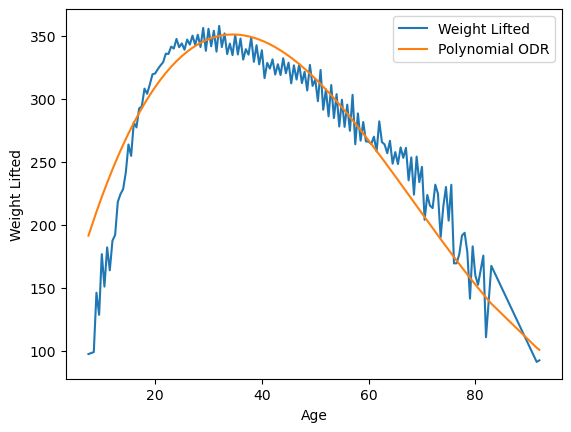

In [72]:
pord(total,'F',3)

Peak Mean Weight Lifted is at: 36.5 years old.
Recovered equation: y = -51.42 + 41.26x^1 + -0.78x^2 + 0.00x^3, t=-0.80, p=4.25e-01
R_Squared: 0.8599893217725161


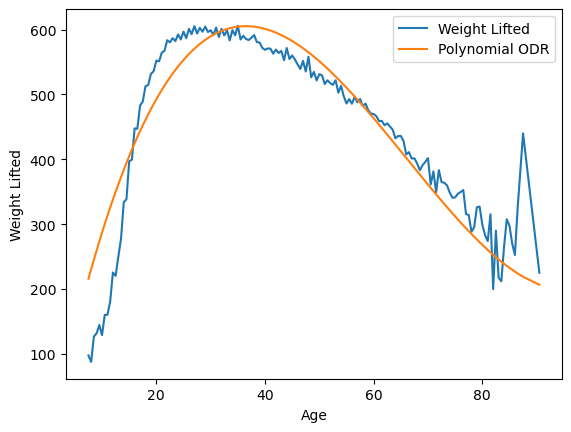

In [73]:
pord(total,'M',3)

Squat

Peak Mean Weight Lifted is at: 34.0 years old.
Recovered equation: y = 18.74 + 7.13x^1 + -0.14x^2 + 0.00x^3, t=3.22, p=1.60e-03
R_Squared: 0.8976876002322601


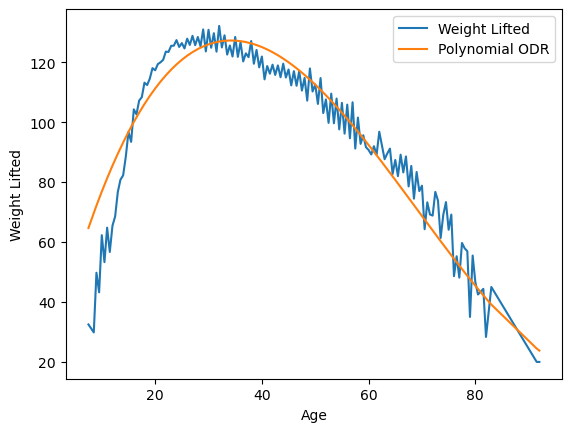

In [74]:
pord(squat,'F',3)

Peak Mean Weight Lifted is at: 35.5 years old.
Recovered equation: y = 1.70 + 13.72x^1 + -0.26x^2 + 0.00x^3, t=0.13, p=8.99e-01
R_Squared: 0.8348253455205581


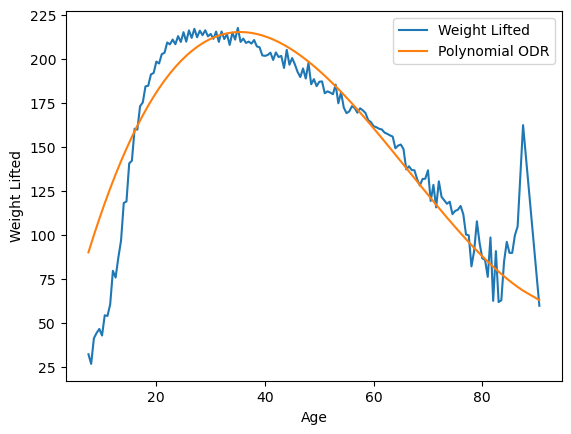

In [75]:
pord(squat,'M',3)

Bench

Peak Mean Weight Lifted is at: 36.0 years old.
Recovered equation: y = 5.87 + 4.14x^1 + -0.08x^2 + 0.00x^3, t=1.88, p=6.23e-02
R_Squared: 0.8960267133591164


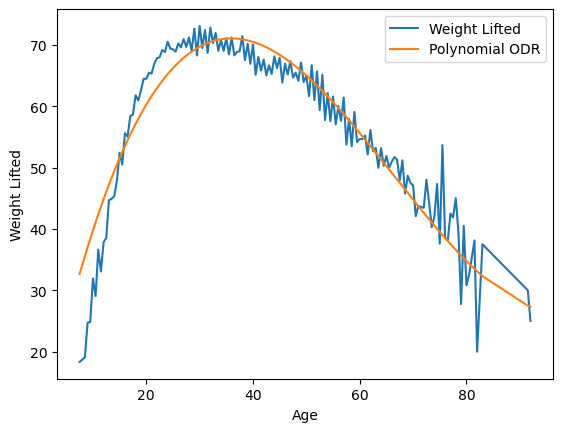

In [76]:
pord(bench,'F',3)

Peak Mean Weight Lifted is at: 37.5 years old.
Recovered equation: y = -8.91 + 9.28x^1 + -0.17x^2 + 0.00x^3, t=-1.10, p=2.74e-01
R_Squared: 0.8618564851284553


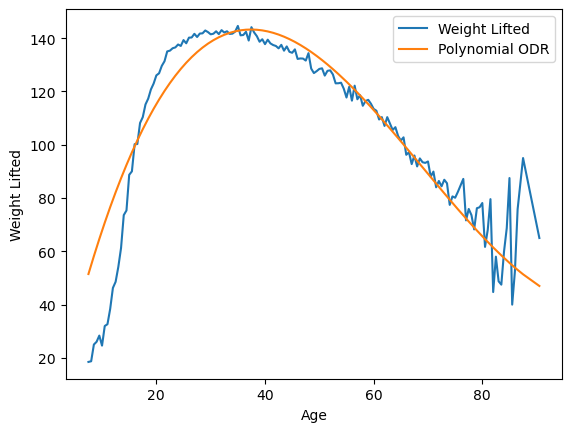

In [77]:
pord(bench,'M',3)

Deadlift

Peak Mean Weight Lifted is at: 36.5 years old.
Recovered equation: y = 40.43 + 6.71x^1 + -0.12x^2 + 0.00x^3, t=6.06, p=1.04e-08
R_Squared: 0.8543996285259802


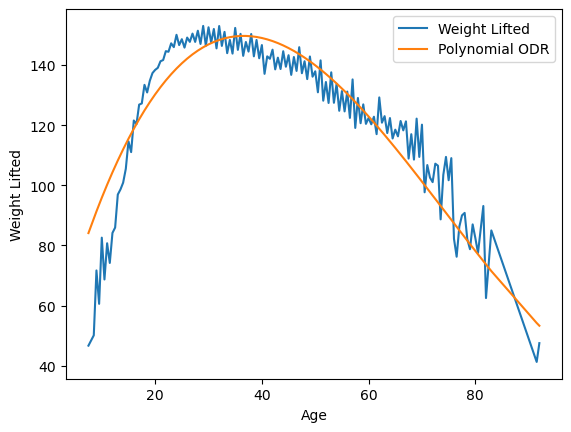

In [78]:
pord(dead,'F',3)

Peak Mean Weight Lifted is at: 35.5 years old.
Recovered equation: y = -13.23 + 16.82x^1 + -0.33x^2 + 0.00x^3, t=-0.72, p=4.74e-01
R_Squared: 0.8341117456599613


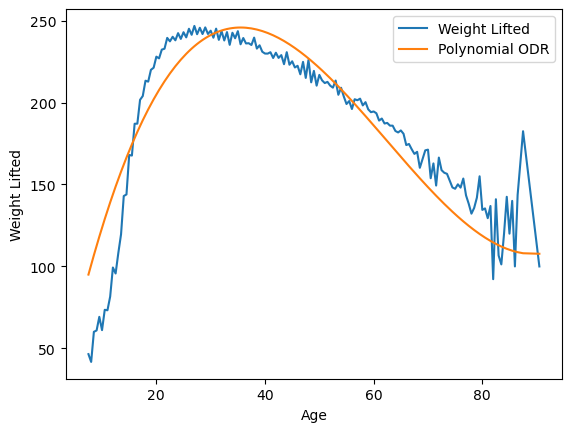

In [79]:
pord(dead,'M',3)

# Top Strength Population

Export the dataframe consisting of top 10% strength for each weight group

In [80]:
max_strength_df(total,'M').to_pickle('DT_Total_M.pkl')
max_strength_df(squat,'M').to_pickle('DT_Squat_M.pkl')
max_strength_df(bench,'M').to_pickle('DT_Bench_M.pkl')
max_strength_df(dead,'M').to_pickle('DT_Dead_M.pkl')

max_strength_df(total,'F').to_pickle('DT_Total_F.pkl')
max_strength_df(squat,'F').to_pickle('DT_Squat_F.pkl')
max_strength_df(bench,'F').to_pickle('DT_Bench_F.pkl')
max_strength_df(dead,'F').to_pickle('DT_Dead_F.pkl')